# Sample Solutions and Hints

__actuarialmath -- Life Contingent Risks with Python__

This package implements fundamental methods for modeling life contingent risks, and closely follows traditional topics covered in actuarial exams and standard texts such as the "Fundamentals of Actuarial Math - Long-term" exam syllabus by the Society of Actuaries, and "Actuarial Mathematics for Life Contingent Risks" by Dickson, Hardy and Waters.  These code chunks demonstrate how to solve each of the sample FAM-L exam questions released by the SOA.

Sources:

- SOA FAM-L Sample Solutions: [copy retrieved Aug 2022](https://terence-lim.github.io/notes/2022-10-exam-fam-l-sol.pdf)

- SOA FAM-L Sample Questions: [copy retrieved Aug 2022](https://terence-lim.github.io/notes/2022-10-exam-fam-l-quest.pdf)

- [Online User Guide](https://terence-lim.github.io/actuarialmath-guide/), or [download pdf](https://terence-lim.github.io/notes/actuarialmath-guide.pdf)

- [API reference](https://terence-lim.github.io/actuarialmath-docs)

- [Github repo](https://github.com/terence-lim/actuarialmath.git) and [issues](https://github.com/terence-lim/actuarialmath/issues)


In [1]:
#! pip install actuarialmath==0.0.9

In [2]:
"""Solutions code and hints for SOA FAM-L sample questions

MIT License.  Copyright 2022-2023, Terence Lim
"""
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from actuarialmath import Interest
from actuarialmath import Life
from actuarialmath import Survival
from actuarialmath import Lifetime
from actuarialmath import Fractional
from actuarialmath import Insurance
from actuarialmath import Annuity
from actuarialmath import Premiums
from actuarialmath import PolicyValues, Contract
from actuarialmath import Reserves
from actuarialmath import Recursion
from actuarialmath import LifeTable
from actuarialmath import SULT
from actuarialmath import SelectLife
from actuarialmath import MortalityLaws, Beta, Uniform, Makeham, Gompertz
from actuarialmath import ConstantForce
from actuarialmath import ExtraRisk
from actuarialmath import Mthly
from actuarialmath import UDD
from actuarialmath import Woolhouse

__Helper to compare computed answers to expected solutions__

In [3]:
class IsClose:
    """Helper class for testing and reporting if two values are close"""
    def __init__(self, rel_tol : float = 0.01, score : bool = False,
                 verbose: bool = False):
        self.den = self.num = 0
        self.score = score      # whether to count INCORRECTs instead of assert
        self.verbose = verbose  # whether to run silently
        self.incorrect = []     # to keep list of messages for INCORRECT
        self.tol = rel_tol

    def __call__(self, solution, answer, question="", rel_tol=None):
        """Compare solution to answer within relative tolerance

        Args:
          solution (str | numeric) : gold label
          answer (str | numeric) : computed answer
          question (str) : label to associate with this test
          rel_tol (float) : relative tolerance to be considered close
        """
        if isinstance(solution, str):
            isclose = (solution == answer)
        else:
            isclose = math.isclose(solution, answer, rel_tol=rel_tol or self.tol)
        self.den += 1
        self.num += isclose
        msg = f"{question} {solution}: {answer}"
        if self.verbose:
            print("-----", msg, "[OK]" if isclose else "[INCORRECT]", "-----")
        if not self.score:
            assert isclose, msg
        if not isclose:
            self.incorrect.append(msg)
        return isclose

    def __str__(self):
        """Display cumulative score and errors"""
        return f"Passed: {self.num}/{self.den}\n" + "\n".join(self.incorrect)
isclose = IsClose(0.01, score=False, verbose=True)

## 1 Tables


These tables are provided in the FAM-L exam
- Interest Functions at i=0.05
- Normal Distribution Table
- Standard Ultimate Life Table

but you actually do not need them here!

In [4]:
print("Interest Functions at i=0.05")
UDD.interest_frame()

Interest Functions at i=0.05


,i(m),d(m),i/i(m),d/d(m),alpha(m),beta(m)
1,0.05000,0.04762,1.00000,1.00000,1.00000,0.00000
2,0.04939,0.04820,1.01235,0.98795,1.00015,0.25617
4,0.04909,0.04849,1.01856,0.98196,1.00019,0.38272
12,0.04889,0.04869,1.02271,0.97798,1.00020,0.46651
0,0.04879,0.04879,1.02480,0.97600,1.00020,0.50823


In [5]:
print("Values of z for selected values of Pr(Z<=z)")
print(Life.quantiles_frame().to_string(float_format=lambda x: f"{x:.3f}"))

Values of z for selected values of Pr(Z<=z)
z         0.842  1.036  1.282  1.645  1.960  2.326  2.576
Pr(Z<=z)  0.800  0.850  0.900  0.950  0.975  0.990  0.995


In [6]:
print("Standard Ultimate Life Table at i=0.05")
SULT().frame()

Standard Ultimate Life Table at i=0.05


,l_x,q_x,a_x,A_x,2A_x,a_x:10,A_x:10,a_x:20,A_x:20,5_E_x,10_E_x,20_E_x
20,100000.0,0.000250,19.9664,0.04922,0.00580,8.0991,0.61433,13.0559,0.37829,0.78252,0.61224,0.37440
21,99975.0,0.000253,19.9197,0.05144,0.00614,8.0990,0.61433,13.0551,0.37833,0.78250,0.61220,0.37429
22,99949.7,0.000257,19.8707,0.05378,0.00652,8.0988,0.61434,13.0541,0.37837,0.78248,0.61215,0.37417
23,99924.0,0.000262,19.8193,0.05622,0.00694,8.0986,0.61435,13.0531,0.37842,0.78245,0.61210,0.37404
24,99897.8,0.000267,19.7655,0.05879,0.00739,8.0983,0.61437,13.0519,0.37848,0.78243,0.61205,0.37390
...,...,...,...,...,...,...,...,...,...,...,...,...
96,17501.8,0.192887,3.5597,0.83049,0.69991,3.5356,0.83164,3.5597,0.83049,0.19872,0.01330,0.00000
97,14125.9,0.214030,3.3300,0.84143,0.71708,3.3159,0.84210,3.3300,0.84143,0.16765,0.00827,0.00000
98,11102.5,0.237134,3.1127,0.85177,0.73356,3.1050,0.85214,3.1127,0.85177,0.13850,0.00485,0.00000
99,8469.7,0.262294,2.9079,0.86153,0.74930,2.9039,0.86172,2.9079,0.86153,0.11173,0.00266,0.00000


## 2 Survival models

__SOA Question 2.1__ : (B) 2.5

You are given:

1. $S0(t) = \left(1 - \frac{t}{\omega} \right)^{\frac{1}{4}}, \quad 0 \le t \le \omega$

2. $\mu_{65} = \frac{1}{180} $

Calculate $e_{106}$, the curtate expectation of life at age 106.

*hints:*

- derive formula for $\mu$ from given survival function
- solve for $\omega$ given $\mu_{65}$
- calculate $e$ by summing survival probabilities


In [7]:
life = Lifetime()
def mu_from_l(omega):   # first solve for omega, given mu_65 = 1/180            
    return life.set_survival(l=lambda x,s: (1 - (x+s)/omega)**0.25).mu_x(65)
omega = int(life.solve(mu_from_l, target=1/180, grid=100))
e = life.set_survival(l=lambda x,s:(1 - (x + s)/omega)**.25, maxage=omega)\
        .e_x(106)       # then solve expected lifetime from omega              
isclose(2.5, e, question="Q2.1")

----- Q2.1 2.5: 2.4786080555423604 [OK] -----


True

__SOA Question 2.2__ : (D) 400

Scientists are searching for a vaccine for a disease. You are given:
1. 100,000 lives age x are exposed to the disease
2. Future lifetimes are independent, except that the vaccine, if available, will be given to all at the end of year 1
3. The probability that the vaccine will be available is 0.2
4. For each life during year 1, $q_x$ = 0.02
5. For each life during year 2, $q_{x+1}$ = 0.01 if the vaccine has been given and $q_{x+1}$ = 0.02 if it has not been given

Calculate the standard deviation of the number of survivors at the end of year 2.

*hints:*


- calculate survival probabilities for the two scenarios
- apply conditional variance formula (or mixed distribution)

In [8]:
p1 = (1. - 0.02) * (1. - 0.01)  # 2_p_x if vaccine given
p2 = (1. - 0.02) * (1. - 0.02)  # 2_p_x if vaccine not given
std = math.sqrt(Life.conditional_variance(p=.2, p1=p1, p2=p2, N=100000))
isclose(400, std, question="Q2.2")

----- Q2.2 400: 396.5914603215815 [OK] -----


True

__SOA Question 2.3__ : (A) 0.0483

You are given that mortality follows Gompertz Law with B = 0.00027 and c = 1.1.

Calculate $f_{50}(10)$.


*hints:*


- Derive formula for $f$ given survival function

In [9]:
B, c = 0.00027, 1.1
S = lambda x,s,t: math.exp(-B * c**(x+s) * (c**t - 1)/math.log(c))
life = Survival().set_survival(S=S)
f = life.f_x(x=50, t=10)
isclose(0.0483, f, question="Q2.3")

----- Q2.3 0.0483: 0.048327399045049846 [OK] -----


True

__SOA Question 2.4__ : (E) 8.2


You are given $_tq_0 = \frac{t^2}{10,000} \quad 0 < t < 100$. Calculate 
$\overset{\circ}{e}_{75:\overline{10|}}$.


*hints:*


- derive survival probability function $_tp_x$ given $_tq_0$
- compute $\overset{\circ}{e}$ by integration


In [10]:
def l(x, s): return 0. if (x+s) >= 100 else 1 - ((x + s)**2) / 10000.
e = Lifetime().set_survival(l=l).e_x(75, t=10, curtate=False)
isclose(8.2, e, question="Q2.4")

----- Q2.4 8.2: 8.20952380952381 [OK] -----


True

__SOA Question 2.5__ :  (B) 37.1

You are given the following:
1. $e_{40:20} = 18$
2. $e_{60} = 25$
3. $_{20}q_{40} = 0.2$
4. $q_{40} = 0.003$

Calculate $e_{41}$.

*hints:*


- solve for $e_{40}$ from limited lifetime formula
- compute $e_{41}$ using backward recursion

In [11]:
life = Recursion(verbose=False).set_e(25, x=60, curtate=True)\
                               .set_q(0.2, x=40, t=20)\
                               .set_q(0.003, x=40)
def fun(e):   # solve e_40 from e_40:20 = e_40 - 20_p_40 e_60
    return life.set_e(e, x=40, curtate=True)\
               .e_x(x=40, t=20, curtate=True)
e40 = life.solve(fun, target=18, grid=[36, 41])
life.verbose=True
fun(e40)
e41 = life.e_x(41, curtate=True)
isclose(37.1, e41, question="Q2.5")

----- Q2.5 37.1: 37.11434302908726 [OK] -----


True

__SOA Question 2.6__ : (C) 13.3

You are given the survival function:

$S_0(x) = \left( 1 − \frac{x}{60} \right)^{\frac{1}{3}}, \quad 0 \le x \le 60$

Calculate $1000 \mu_{35}$.

*hints:*


- derive force of mortality function $\mu$ from given survival function


In [12]:
life = Survival().set_survival(l=lambda x,s: (1 - (x+s)/60)**(1/3))
mu = 1000 * life.mu_x(35)
isclose(13.3, mu, question="Q2.6")

----- Q2.6 13.3: 13.340451278922776 [OK] -----


True

__SOA Question 2.7__ : (B) 0.1477

You are given the following survival function of a newborn:

$$
\begin{align*}
S_0(x) & = 1 - \frac{x}{250}, \quad 0 \le x < 40 \\
& = 1 - \left( \frac{x}{100} \right)^2, \quad 40 \le x \le 100
\end{align*}
$$


Calculate the probability that (30) dies within the next 20 years.

*hints:*


- calculate from given survival function

In [13]:
l = lambda x,s: (1-((x+s)/250) if (x+s)<40 else 1-((x+s)/100)**2)
q = Survival().set_survival(l=l).q_x(30, t=20)
isclose(0.1477, q, question="Q2.7")

----- Q2.7 0.1477: 0.1477272727272727 [OK] -----


True

__SOA Question 2.8__ : (C) 0.94

In a population initially consisting of 75% females and 25% males, you are given:

1. For a female, the force of mortality is constant and equals $\mu$
2. For a male, the force of mortality is constant and equals 1.5 $\mu$
3. At the end of 20 years, the population is expected to consist of 85% females and 15% males

Calculate the probability that a female survives one year.

*hints:*


- relate $p_{male}$ and $p_{female}$ through the common term $\mu$ and the given proportions


In [14]:
def fun(mu):  # Solve first for mu, given ratio of start and end proportions
    male = Survival().set_survival(mu=lambda x,s: 1.5 * mu)
    female = Survival().set_survival(mu=lambda x,s: mu)
    return (75 * female.p_x(0, t=20)) / (25 * male.p_x(0, t=20))
mu = Survival.solve(fun, target=85/15, grid=[0.89, 0.99])
p = Survival().set_survival(mu=lambda x,s: mu).p_x(0, t=1)
isclose(0.94, p, question="Q2.8")

----- Q2.8 0.94: 0.9383813306903799 [OK] -----


True

## 3 Life tables and selection

__SOA Question 3.1__ :  (B) 117

You are given:

1. An excerpt from a select and ultimate life table with a select period of 3 years:

| $x$ | $\ell_{[ x ]}$ | $\ell_{[x]+1}$ | $\ell_{[x]+2}$ | $\ell_{x+3}$ | $x+3$ |
|---|---|---|---|---|---|
| 60 | 80,000 | 79,000 | 77,000 | 74,000 | 63 |
| 61 | 78,000 | 76,000 | 73,000 | 70,000 | 64 |
| 62 | 75,000 | 72,000 | 69,000 | 67,000 | 65 |
| 63 | 71,000 | 68,000 | 66,000 | 65,000 | 66 |

2. Deaths follow a constant force of mortality over each year of age

Calculate $1000~ _{23}q_{[60] + 0.75}$.

*hints:*


- interpolate with constant force of maturity


In [15]:
life = SelectLife().set_table(l={60: [80000, 79000, 77000, 74000],
                                 61: [78000, 76000, 73000, 70000],
                                 62: [75000, 72000, 69000, 67000],
                                 63: [71000, 68000, 66000, 65000]})
q = 1000 * life.q_r(60, s=0, r=0.75, t=3, u=2)
isclose(117, q, question="Q3.1")

----- Q3.1 117: 116.7192429022082 [OK] -----


True

__SOA Question 3.2__ :  (D) 14.7

You are given:

1. The following extract from a mortality table with a one-year select period:

$x$ | $l_{[x]}$ | $d_{[x]}$ | $l_{x+1}$ | $x + 1$ |
|---|---|---|---|---|
| 65 | 1000 | 40 | − | 66 |
| 66 | 955 | 45 | − | 67 |

2. Deaths are uniformly distributed over each year of age

$\overset{\circ}{e}_{[65]} = 15.0$

Calculate $\overset{\circ}{e}_{[66]}$.

*hints:*


- UDD $\Rightarrow \overset{\circ}{e}_{x} = e_x + 0.5$
- fill select table using curtate expectations 


In [16]:
e_curtate = Fractional.e_approximate(e_complete=15)
life = SelectLife(udd=True).set_table(l={65: [1000, None,],
                                         66: [955, None]},
                                      e={65: [e_curtate, None]},
                                      d={65: [40, None,],
                                         66: [45, None]})
e = life.e_r(66)
isclose(14.7, e, question="Q3.2")

----- Q3.2 14.7: 14.67801047120419 [OK] -----


True

__SOA Question 3.3__ :  (E) 1074

You are given:

1. An excerpt from a select and ultimate life table with a select period of 2 years:

| $x$ | $\ell_{[ x ]}$ | $\ell_{[ x ] + 1}$ | $\ell_{x + 2}$ | $x + 2$ |
|---|---|---|---|---|
| 50 | 99,000 | 96,000 | 93,000 | 52 |
| 51 | 97,000 | 93,000 | 89,000 | 53 |
| 52 | 93,000 | 88,000 | 83,000 | 54 |
| 53 | 90,000 | 84,000 | 78,000 | 55 |

2. Deaths are uniformly distributed over each year of age

Calculate $10,000 ~ _{2.2}q_{[51]+0.5}$.

*hints:*


- interpolate lives between integer ages with UDD

In [17]:
life = SelectLife().set_table(l={50: [99, 96, 93],
                                 51: [97, 93, 89],
                                 52: [93, 88, 83],
                                 53: [90, 84, 78]})
q = 10000 * life.q_r(51, s=0, r=0.5, t=2.2)
isclose(1074, q, question="Q3.3")

----- Q3.3 1074: 1073.684210526316 [OK] -----


True

__SOA Question 3.4__ :  (B) 815

The SULT Club has 4000 members all age 25 with independent future lifetimes. The
mortality for each member follows the Standard Ultimate Life Table.

Calculate the largest integer N, using the normal approximation, such that the probability that there are at least N survivors at age 95 is at least 90%.


*hints:*


- compute portfolio percentile with N=4000, and mean and variance  from binomial distribution

In [18]:
sult = SULT()
mean = sult.p_x(25, t=95-25)
var = sult.bernoulli(mean, variance=True)
pct = sult.portfolio_percentile(N=4000, mean=mean, variance=var, prob=0.1)
isclose(815, pct, question="Q3.4")

----- Q3.4 815: 815.0943255167722 [OK] -----


True

__SOA Question 3.5__ :  (E) 106


You are given:
| $x$ | 60 | 61 | 62 | 63 |64 | 65 | 66 | 67 |
|---|---|---|---|---|---|---|---|---|
| $l_x$ | 99,999 | 88,888 |77,777 | 66,666 | 55,555 | 44,444 | 33,333 | 22,222|

$a =~ _{3.4|2.5}q_{60}$ assuming a uniform distribution of deaths over each year of age

$b =~ _{3.4|2.5}q_{60}$ assuming a constant force of mortality over each year of age

Calculate $100,000( a − b )$

*hints:*


- compute mortality rates by interpolating lives between integer ages, with UDD and constant force of mortality assumptions

In [19]:
l = [99999, 88888, 77777, 66666, 55555, 44444, 33333, 22222]
a = LifeTable(udd=True).set_table(l={age:l for age,l in zip(range(60, 68), l)})\
                       .q_r(60, u=3.4, t=2.5)
b = LifeTable(udd=False).set_table(l={age:l for age,l in zip(range(60, 68), l)})\
                        .q_r(60, u=3.4, t=2.5)
isclose(106, 100000 * (a - b), question="Q3.5")

----- Q3.5 106: 106.16575827938624 [OK] -----


True

__SOA Question 3.6__ :  (D) 15.85

You are given the following extract from a table with a 3-year select period:

| $x$ | $q_{[x]}$ | $q_{[x]+1}$ | $q_{[x]+2}$ | $q_{x+3}$ | $x+3$ |
|---|---|---|---|---|---|
| 60 | 0.09 | 0.11 | 0.13 | 0.15 | 63 |
| 61 | 0.10 | 0.12 | 0.14 | 0.16 | 64 |
| 62 | 0.11 | 0.13 | 0.15 | 0.17 | 65 |
| 63 | 0.12 | 0.14 | 0.16 | 0.18 | 66 |
| 64 | 0.13 | 0.15 | 0.17 | 0.19 | 67 |

$e_{64} = 5.10$

Calculate $e_{[61]}$.

*hints:*


- apply recursion formulas for curtate expectation


In [20]:
e = SelectLife().set_table(q={60: [.09, .11, .13, .15],
                              61: [.1, .12, .14, .16],
                              62: [.11, .13, .15, .17],
                              63: [.12, .14, .16, .18],
                              64: [.13, .15, .17, .19]},
                           e={61: [None, None, None, 5.1]})\
                .e_x(61)
isclose(5.85, e, question="Q3.6")

----- Q3.6 5.85: 5.846832 [OK] -----


True

__SOA Question 3.7__ : (b) 16.4

For a mortality table with a select period of two years, you are given:

| $x$ | $q_{[x]}$ | $q_{[x]+1}$ | $q_{x+2}$ | $x+2$ |
|---|---|---|---|---|
| 50 | 0.0050 | 0.0063 | 0.0080 | 52 |
| 51 | 0.0060 | 0.0073 | 0.0090 | 53 |
| 52 | 0.0070 | 0.0083 | 0.0100 | 54 |
| 53 | 0.0080 | 0.0093 | 0.0110 | 55 |

The force of mortality is constant between integral ages.

Calculate $1000 ~_{2.5}q_{[50]+0.4}$.

*hints:*


- use deferred mortality formula
- use chain rule for survival probabilities,
- interpolate between integer ages with constant force of mortality


In [21]:
life = SelectLife().set_table(q={50: [.0050, .0063, .0080],
                                 51: [.0060, .0073, .0090],
                                 52: [.0070, .0083, .0100],
                                 53: [.0080, .0093, .0110]})
q = 1000 * life.q_r(50, s=0, r=0.4, t=2.5)
isclose(16.4, q, question="Q3.7")

----- Q3.7 16.4: 16.420207214428586 [OK] -----


True

__SOA Question 3.8__ :  (B) 1505

A club is established with 2000 members, 1000 of exact age 35 and 1000 of exact age 45. You are given:
1. Mortality follows the Standard Ultimate Life Table
2. Future lifetimes are independent
3. N is the random variable for the number of members still alive 40 years after the club is established

Using the normal approximation, without the continuity correction, calculate the smallest $n$ such that $Pr( N \ge n ) \le 0.05$.

*hints:*


- compute portfolio means and variances from sum of 2000 independent members' means and variances of survival.


In [22]:
sult = SULT()
p1 = sult.p_x(35, t=40)
p2 = sult.p_x(45, t=40)
mean = sult.bernoulli(p1) * 1000 + sult.bernoulli(p2) * 1000
var = (sult.bernoulli(p1, variance=True) * 1000 
       + sult.bernoulli(p2, variance=True) * 1000)
pct = sult.portfolio_percentile(mean=mean, variance=var, prob=.95)
isclose(1505, pct, question="Q3.8")

----- Q3.8 1505: 1504.8328375406456 [OK] -----


True

__SOA Question 3.9__ :  (E) 3850

A father-son club has 4000 members, 2000 of which are age 20 and the other 2000 are age 45. In 25 years, the members of the club intend to hold a reunion.

You are given:
1. All lives have independent future lifetimes.
2. Mortality follows the Standard Ultimate Life Table.

Using the normal approximation, without the continuity correction, calculate the 99th percentile of the number of surviving members at the time of the reunion.

*hints:*


- compute portfolio means and variances as sum of 4000 independent members' means and variances (of survival)
- retrieve normal percentile


In [23]:
sult = SULT()
p1 = sult.p_x(20, t=25)
p2 = sult.p_x(45, t=25)
mean = sult.bernoulli(p1) * 2000 + sult.bernoulli(p2) * 2000
var = (sult.bernoulli(p1, variance=True) * 2000 
       + sult.bernoulli(p2, variance=True) * 2000)
pct = sult.portfolio_percentile(mean=mean, variance=var, prob=.99)
isclose(3850, pct, question="Q3.9")

----- Q3.9 3850: 3850.144345130047 [OK] -----


True

__SOA Question 3.10__ :  (C) 0.86

A group of 100 people start a Scissor Usage Support Group. The
rate at which members
enter and leave the group is dependent on whether they are right-handed or left-handed.

You are given the following:

1. The initial membership is made up of 75% left-handed members (L)
 and 25% right-handed members (R)

2. After the group initially forms, 35 new (L) and 15 new (R) join
 the group at the
 start of each subsequent year

3. Members leave the group only at the end of each year

4. $q_L$ = 0.25 for all years

5. $q_R$ = 0.50 for all years

 Calculate the proportion of the Scissor Usage Support Group's expected
 membership that is left-handed at the start of the group's 6th year, before any new members join for that year.

*hints:*


- reformulate the problem by reversing time: survival to year 6 is calculated in reverse as discounting by the same number of years. 



In [24]:
interest = Interest(v=0.75)
L = 35*interest.annuity(t=4, due=False) + 75*interest.v_t(t=5)
interest = Interest(v=0.5)
R = 15*interest.annuity(t=4, due=False) + 25*interest.v_t(t=5)
isclose(0.86, L / (L + R), question="Q3.10")

----- Q3.10 0.86: 0.8578442833761983 [OK] -----


True

__SOA Question 3.11__ :  (B) 0.03

For the country of Bienna, you are given:
1. Bienna publishes mortality rates in biennial form, that is, mortality rates are of the form: $_2q_{2x},$ for $x = 0,1, 2,...$

2. Deaths are assumed to be uniformly distributed between ages $2x$ and $2x + 2$, for $x = 0,1, 2,...$
3. $_2q_{50} = 0.02$
4. $_2q_{52} = 0.04$

Calculate the probability that (50) dies during the next 2.5 years.

*hints:*


- calculate mortality rate by interpolating lives assuming UDD


In [25]:
life = LifeTable(udd=True).set_table(q={50//2: .02, 52//2: .04})
q = life.q_r(50//2, t=2.5/2)
isclose(0.03, q, question="Q3.11")

----- Q3.11 0.03: 0.0298 [OK] -----


True

__SOA Question 3.12__ : (C) 0.055 

X and Y are both age 61. X has just purchased a whole life insurance policy. Y purchased a whole life insurance policy one year ago.

Both X and Y are subject to the following 3-year select and ultimate table:

| $x$ | $\ell_{[x]}$ | $\ell_{[x]+1}$ | $\ell_{[x] + 2}$ | $\ell_{x+3}$ | $x+3$ |
|---|---|---|---|---|---|
| 60 | 10,000 | 9,600 | 8,640 | 7,771 | 63 |
| 61 | 8,654 | 8,135 | 6,996 | 5,737 | 64 |
| 62 | 7,119 | 6,549 | 5,501 | 4,016 | 65 |
| 63 | 5,760 | 4,954 | 3,765 | 2,410 | 66 |

The force of mortality is constant over each year of age.

Calculate the difference in the probability of survival to age 64.5 between X and Y.

*hints:*


- compute survival probability by interpolating lives assuming constant force


In [26]:
life = SelectLife(udd=False).set_table(l={60: [10000, 9600, 8640, 7771],
                                          61: [8654, 8135, 6996, 5737],
                                          62: [7119, 6549, 5501, 4016],
                                          63: [5760, 4954, 3765, 2410]})
q = life.q_r(60, s=1, t=3.5) - life.q_r(61, s=0, t=3.5)               
isclose(0.055, q, question="Q3.12")

----- Q3.12 0.055: 0.05465655938591829 [OK] -----


True

__SOA Question 3.13__ :  (B) 1.6

A life is subject to the following 3-year select and ultimate table:

| $[x]$ | $\ell_{[x]}$ | $\ell_{[x]+1}$ | $\ell_{[x]+2}$ | $\ell_{x+3}$ | $x+3$ |
|---|---|---|---|---|---
| 55 | 10,000 | 9,493 | 8,533 | 7,664 | 58 |
| 56 | 8,547 | 8,028 | 6,889 | 5,630 | 59 |
| 57 | 7,011 | 6,443 | 5,395 | 3,904 | 60 |
| 58 | 5,853 | 4,846 | 3,548 | 2,210 | 61 |

You are also given:
1. $e_{60} = 1$
2. Deaths are uniformly distributed over each year of age

Calculate $\overset{\circ}{e}_{[58]+2}$ .

*hints:*


- compute curtate expectations using recursion formulas
- convert to complete expectation assuming UDD


In [27]:
life = SelectLife().set_table(l={55: [10000, 9493, 8533, 7664],
                                 56: [8547, 8028, 6889, 5630],
                                 57: [7011, 6443, 5395, 3904],
                                 58: [5853, 4846, 3548, 2210]},
                              e={57: [None, None, None, 1]})
e = life.e_r(58, s=2)
isclose(1.6, e, question="Q3.13")

----- Q3.13 1.6: 1.6003382187147688 [OK] -----


True

__SOA Question 3.14__ :  (C) 0.345

You are given the following information from a life table:

| x | $l_x$ | $d_x$ | $p_x$ | $q_x$ |
|---|---|---|---|---|
| 95 | − | − | − | 0.40 |
| 96 | − | − | 0.20 | − |
| 97 | − | 72 | − | 1.00 |

You are also given:
1. $l_{90} = 1000$ and $l_{93} = 825$
2. Deaths are uniformly distributed over each year of age.

Calculate the probability that (90) dies between ages 93 and 95.5.

*hints:*


- compute mortality by interpolating lives between integer ages assuming UDD


In [28]:
life = LifeTable(udd=True).set_table(l={90: 1000, 93: 825},
                                     d={97: 72},
                                     p={96: .2},
                                     q={95: .4, 97: 1})
q = life.q_r(90, u=93-90, t=95.5 - 93)
isclose(0.345, q, question="Q3.14")

----- Q3.14 0.345: 0.345 [OK] -----


True

## 4 Insurance benefits

__SOA Question 4.1__ :  (A) 0.27212

For a special whole life insurance policy issued on (40), you
are given:

1. Death benefits are payable at the end of the year of death

2. The amount of benefit is 2 if death occurs within the first 20
 years and is 1 thereafter

3. *Z* is the present value random variable for the payments
 under this insurance

4. *i* = 0.03

5. 
| x | $A_x$ | $_{20}E_x$ |
|---|---|---|
| 40 | 0.36987 | 0.51276 |
| 60 | 0.62567 | 0.17878 |


6. $E[Z^2] =0.24954$

Calculate the standard deviation of *Z*.


*hints:*


- solve EPV as sum of term and deferred insurance
- compute variance as difference of second moment and first moment squared


In [29]:
life = Recursion().set_interest(i=0.03)
life.set_A(0.36987, x=40).set_A(0.62567, x=60)
life.set_E(0.51276, x=40, t=20).set_E(0.17878, x=60, t=20)
Z2 = 0.24954
A = (2 * life.term_insurance(40, t=20) + life.deferred_insurance(40, u=20))
std = math.sqrt(life.insurance_variance(A2=Z2, A1=A))
isclose(0.27212, std, question="Q4.1")

----- Q4.1 0.27212: 0.2721117749374753 [OK] -----


True

__SOA Question 4.2__ :  (D) 0.18

or a special 2-year term insurance policy on (*x*), you are
given:

1. Death benefits are payable at the end of the half-year of death

2. The amount of the death benefit is 300,000 for the first
 half-year and increases by 30,000 per half-year thereafter

3. *q* = *x* 0.16 and *q* + = 0.23

4. *i* (2) = 0.18

5. Deaths are assumed to follow a constant force of mortality
 between integral ages

6. *Z* is the present value random variable for this insurance

Calculate Pr( *Z* \> 277,000) .

*hints:*


- calculate Z(t) and deferred mortality for each half-yearly t
- sum the deferred mortality probabilities for periods when PV > 277000 


In [30]:
life = LifeTable(udd=False).set_table(q={0: .16, 1: .23})\
                           .set_interest(i_m=.18, m=2)
mthly = Mthly(m=2, life=life)
Z = mthly.Z_m(0, t=2, benefit=lambda x,t: 300000 + t*30000*2)
p = Z[Z['Z'] >= 277000]['q'].sum()
isclose(0.18, p, question="Q4.2")

----- Q4.2 0.18: 0.17941813045022975 [OK] -----


True

__SOA Question 4.3__ : (D) 0.878

You are given:

1. $q_{60} = 0.01$
2. Using $i = 0.05, ~ A_{60:\overline{3|}} = 0.86545$
3. Using $i = 0.045$ calculate $A_{60:\overline{3|}}$

*hints:*


- solve $q_{61}$ from endowment insurance EPV formula
- solve $A_{60:\overline{3|}}$ with new $i=0.045$ as EPV of endowment insurance benefits.


In [31]:
life = Recursion(verbose=False).set_interest(i=0.05).set_q(0.01, x=60)
def fun(q):   # solve for q_61
    return life.set_q(q, x=61).endowment_insurance(60, t=3)
life.solve(fun, target=0.86545, grid=0.01)
A = life.set_interest(i=0.045).endowment_insurance(60, t=3)
isclose(0.878, A, question="Q4.3")

----- Q4.3 0.878: 0.8777667236003878 [OK] -----


True

__SOA Question 4.4  (A) 0.036

For a special increasing whole life insurance on (40), payable at the moment of death, you are given__ :
1. The death benefit at time t is $b_t = 1 + 0.2 t, \quad t \ge 0$
2. The interest discount factor at time t is $v(t) = (1 + 0.2 t ) − 2, \quad t \ge 0$
3. $_tp_{40} ~ \mu_{40+t} = 0.025~\text{if} ~ 0 \le t < 40$, otherwise $0$
4. Z is the present value random variable for this insurance

Calculate Var(Z).

*hints:*


- integrate to find EPV of $Z$ and $Z^2$
- variance is difference of second moment and first moment squared


In [32]:
x = 40
life = Insurance().set_survival(f=lambda *x: 0.025, maxage=x+40)\
                  .set_interest(v_t=lambda t: (1 + .2*t)**(-2))
def benefit(x,t): return 1 + .2 * t
A1 = life.A_x(x, benefit=benefit, discrete=False)
A2 = life.A_x(x, moment=2, benefit=benefit, discrete=False)
var = A2 - A1**2
isclose(0.036, var, question="Q4.4")

----- Q4.4 0.036: 0.03567680106032681 [OK] -----


True

__SOA Question 4.5__ :  (C) 35200

For a 30-year term life insurance of 100,000 on (45), you are given:
1. The death benefit is payable at the moment of death
2. Mortality follows the Standard Ultimate Life Table
3. $\delta = 0.05$
4. Deaths are uniformly distributed over each year of age

Calculate the 95th percentile of the present value of benefits random variable for this insurance

*hints:*


- interpolate between integer ages with UDD, and find lifetime that mortality rate exceeded
- compute PV of death benefit paid at that time.


In [33]:
sult = SULT(udd=True).set_interest(delta=0.05)
Z = 100000 * sult.Z_from_prob(45, 0.95, discrete=False)
isclose(35200, Z, question="Q4.5")

----- Q4.5 35200: 35187.952037196534 [OK] -----


True

__SOA Question 4.6__ :  (B) 29.85

For a 3-year term insurance of 1000 on (70), you are given:
1. $q^{SULT}_{70+k}$ is the mortality rate from the Standard Ultimate Life Table, for k = 0,1,2

2. $q_{70 + k}$ is the mortality rate used to price this insurance, for k = 0,1, 2

3. $q_{70 + k} = (0.95)^k q_{70+k}^{SULT}$, for k = 0,1, 2

4. *i* = 0.05

Calculate the single net premium.

*hints:*


- calculate adjusted mortality rates
- compute term insurance as EPV of benefits

In [34]:
sult = SULT()
life = LifeTable().set_interest(i=0.05)\
                  .set_table(q={70+k: .95**k * sult.q_x(70+k) for k in range(3)})
A = life.term_insurance(70, t=3, b=1000)
isclose(29.85, A, question="Q4.6")

----- Q4.6 29.85: 29.84835110355902 [OK] -----


True

__SOA Question 4.7__ :  (B) 0.06

For a 25-year pure endowment of 1 on (*x*), you are given:

1. *Z* is the present value random variable at issue of the benefit
 payment

2. *Var (Z)* = 0.10 *E[Z]*

3. $_{25}p_x = 0.57$

 Calculate the annual effective interest rate.

*hints:*

- use Bernoulli shortcut formula for variance of pure endowment Z 
- solve for $i$, since $p$ is given.

In [35]:
def fun(i):
    life = Recursion(verbose=False).set_interest(i=i)\
                                   .set_p(0.57, x=0, t=25)
    return 0.1*life.E_x(0, t=25) - life.E_x(0, t=25, moment=life.VARIANCE)
i = Recursion.solve(fun, target=0, grid=[0.058, 0.066])
isclose(0.06, i, question="Q4.7")

----- Q4.7 0.06: 0.06008023738770262 [OK] -----


True

__SOA Question 4.8  (C) 191

For a whole life insurance of 1000 on (50), you are given__ :

1. The death benefit is payable at the end of the year of death

2. Mortality follows the Standard Ultimate Life Table

3. *i* = 0.04 in the first year, and *i* = 0.05 in subsequent
 years

 Calculate the actuarial present value of this insurance.

*hints:*

- use insurance recursion with special interest rate $i=0.04$ in first year.


In [36]:
def v_t(t): return 1.04**(-t) if t < 1 else 1.04**(-1) * 1.05**(-t+1)
A = SULT().set_interest(v_t=v_t).whole_life_insurance(50, b=1000)
isclose(191, A, question="Q4.8")

----- Q4.8 191: 191.1281281882354 [OK] -----


True

__SOA Question 4.9__ :  (D) 0.5

You are given:

1. $A_{35:\overline{15|}} = 0.39$
2. $A^1_{35:\overline{15|}} = 0.25$
4. $A_{35} = 0.32$

Calculate $A_{50}$.

*hints:*


- use whole-life, term and endowment insurance relationships.


In [37]:
E = Recursion().set_A(0.39, x=35, t=15, endowment=1)\
               .set_A(0.25, x=35, t=15)\
               .E_x(35, t=15)
life = Recursion().set_A(0.32, x=35)\
                  .set_E(E, x=35, t=15)
def fun(A): return life.set_A(A, x=50).term_insurance(35, t=15)
A = life.solve(fun, target=0.25, grid=[0.35, 0.55])
isclose(0.5, A, question="Q4.9")

 *Pure Endowment E_35(t=15) <--
   E_35(t=15) = A_35(t=15,endow=1) - A_35(t=15)     ~endowment insurance minus term
        a_48(t=1) = 1                               ~one-year discrete annuity
        a_38(t=1) = 1                               ~one-year discrete annuity
        a_53(t=1) = 1                               ~one-year discrete annuity
        a_37(t=1) = 1                               ~one-year discrete annuity
        a_49(t=1) = 1                               ~one-year discrete annuity
        a_36(t=1) = 1                               ~one-year discrete annuity
        a_52(t=1) = 1                               ~one-year discrete annuity
        a_35(t=1) = 1                               ~one-year discrete annuity
        a_50(t=1) = 1                               ~one-year discrete annuity
        a_34(t=1) = 1                               ~one-year discrete annuity
        a_51(t=1) = 1                               ~one-year discrete annuity
        a_33(t=

True

__SOA Question 4.10__ :  (D)

The present value random variable for an insurance policy on (x) is expressed as:
$$\begin{align*}
Z & =0, \quad \textrm{if } T_x \le 10\\
& =v^T, \quad \textrm{if } 10 < T_x \le 20\\
& =2v^T, \quad \textrm{if } 20 < T_x \le 30\\
& =0, \quad \textrm{thereafter}
\end{align*}$$

Determine which of the following is a correct expression for $E[Z]$.


(A) $_{10|}\overline{A}_x + _{20|}\overline{A}_x - _{30|}\overline{A}_x$

(B) $\overline{A}_x + _{20}E_x \overline{A}_{x+20} - 2~_{30}E_x \overline{A}_{x +30}$

(C) $_{10}E_x \overline{A}_x + _{20}E_x \overline{A}_{x+20} - 2 ~_{30}E_x \overline{A}_{x +30}$

(D) $_{10}E_x \overline{A}_{x+10} + _{20}E_x \overline{A}_{x+20} - 2~ _{30}E_x \overline{A}_{x+30}$

(E) $_{10}E_x [\overline{A}_{x} + _{10}E_{x+10} + \overline{A}_{x+20} - _{10}E_{x+20} + \overline{A}_{x+30}]$

*hints:*

- draw and compare benefit diagrams


----- Q4.10 D: D [OK] -----


True

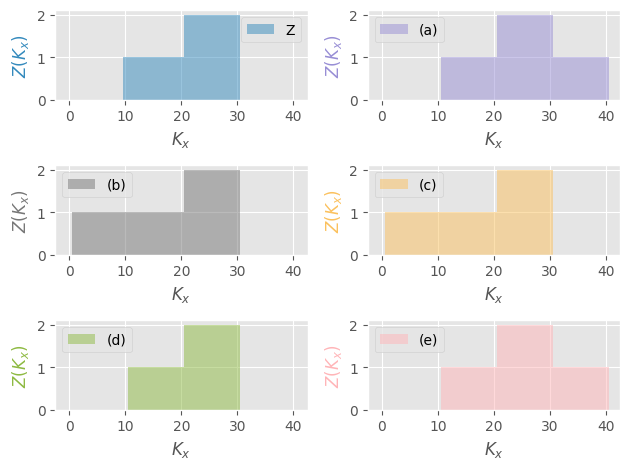

In [38]:
life = Insurance().set_interest(i=0.0).set_survival(S=lambda x,s,t: 1, maxage=40)
def fun(x, t):
    if 10 <= t <= 20: return life.interest.v_t(t)
    elif 20 < t <= 30: return 2 * life.interest.v_t(t)
    else: return 0
def A(x, t):  # Z_x+k (t-k)
    return life.interest.v_t(t - x) * (t > x)
x = 0
benefits=[lambda x,t: (life.E_x(x, t=10) * A(x+10, t)
                            + life.E_x(x, t=20)* A(x+20, t) 
                            - life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (A(x, t)  
                       + life.E_x(x, t=20) * A(x+20, t) 
                       - 2 * life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (life.E_x(x, t=10) * A(x, t) 
                       + life.E_x(x, t=20) * A(x+20, t) 
                       - 2 * life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (life.E_x(x, t=10) * A(x+10, t) 
                       + life.E_x(x, t=20) * A(x+20, t) 
                       - 2 * life.E_x(x, t=30) * A(x+30, t)),
          lambda x,t: (life.E_x(x, t=10)
                       * (A(x+10, t) 
                          + life.E_x(x+10, t=10) * A(x+20, t) 
                          - life.E_x(x+20, t=10) * A(x+30, t)))]
fig, ax = plt.subplots(3, 2)
ax = ax.ravel()
for i, b in enumerate([fun] + benefits):
    life.Z_plot(0, benefit=b, ax=ax[i], color=f"C{i+1}", title='')
    ax[i].legend(["(" + "abcde"[i-1] + ")" if i else "Z"])
z = [sum(abs(b(0, t) - fun(0, t)) for t in range(40)) for b in benefits]
ans = "ABCDE"[np.argmin(z)]
isclose('D', ans, question="Q4.10")

__SOA Question 4.11__ :  (A) 143385

You are given:

1. $Z_1$ is the present value random variable for an n-year term insurance of 1000
issued to (x)
2. $Z_2$ is the present value random variable for an n-year endowment insurance of
1000 issued to (x)
3. For both $Z_1$ and $Z_2$ the death benefit is payable at the end of the year of death
4. $E [ Z_1 ] = 528$
5. $Var ( Z_2 ) = 15,000$
6. $A^{~~~~1}_{x:{\overline{n|}}} = 0.209$
7. $^2A^{~~~~1}_{x:{\overline{n|}}} = 0.136$

Calculate $Var(Z_1)$.

*hints:*


- compute endowment insurance = term insurance + pure endowment 
- apply formula of variance as the difference of second moment and first moment squared.


In [39]:
A1 = 528/1000   # E[Z1]  term insurance
C1 = 0.209      # E[pure_endowment]
C2 = 0.136      # E[pure_endowment^2]
B1 = A1 + C1    # endowment = term + pure_endowment
def fun(A2):
    B2 = A2 + C2   # double force of interest
    return Insurance.insurance_variance(A2=B2, A1=B1)  
A2 = Insurance.solve(fun, target=15000/(1000*1000), grid=[143400, 279300])
var = Insurance.insurance_variance(A2=A2, A1=A1, b=1000)
isclose(143385, var, question="Q4.11")

----- Q4.11 143385: 143384.99999999997 [OK] -----


True

__SOA Question 4.12__ :  (C) 167 

For three fully discrete insurance products on the same (x), you are given:
- $Z_1$ is the present value random variable for a 20-year term insurance of 50
- $Z_2$ is the present value random variable for a 20-year deferred whole life
insurance of 100
- $Z_3$ is the present value random variable for a whole life insurance of 100.
- $E[Z_1] = 1.65$ and $E[Z_2] = 10.75$
- $Var(Z_1) = 46.75$ and $Var(Z_2) = 50.78$

Calculate $Var(Z_3)$.

*hints:*


- since $Z_1,~Z_2$ are non-overlapping, $E[Z_1~ Z_2] = 0$ for computing $Cov(Z_1, Z_2)$
- whole life is sum of term and deferred, hence equals variance of components plus twice their covariance


In [40]:
cov = Life.covariance(a=1.65, b=10.75, ab=0)  # E[Z1 Z2] = 0 nonoverlapping
var = Life.variance(a=2, b=1, var_a=46.75, var_b=50.78, cov_ab=cov)
isclose(167, var, question="Q4.12")

----- Q4.12 167: 166.82999999999998 [OK] -----


True

__SOA Question 4.13__ :  (C) 350 

For a 2-year deferred, 2-year term insurance of 2000 on [65], you are given:

1. The following select and ultimate mortality table with a 3-year select period:

| $x$ | $q_{[x]}$ | $q_{[x]+1}$ | $q_{[x]+2}$ | $q_{x+3}$ | $x+3$ |
|---|---|---|---|---|---
| 65 | 0.08 | 0.10 | 0.12 | 0.14 | 68 |
| 66 | 0.09 | 0.11 | 0.13 | 0.15 | 69 |
| 67 | 0.10 | 0.12 | 0.14 | 0.16 | 70 |
| 68 | 0.11 | 0.13 | 0.15 | 0.17 | 71 |
| 69 | 0.12 | 0.14 | 0.16 | 0.18 | 72 |

2. $i = 0.04$
3. The death benefit is payable at the end of the year of death

Calculate the actuarial present value of this insurance.

*hints:*


- compute term insurance as EPV of benefits

In [41]:
life = SelectLife().set_table(q={65: [.08, .10, .12, .14],
                                 66: [.09, .11, .13, .15],
                                 67: [.10, .12, .14, .16],
                                 68: [.11, .13, .15, .17],
                                 69: [.12, .14, .16, .18]})\
                   .set_interest(i=.04)
A = life.deferred_insurance(65, t=2, u=2, b=2000)
isclose(350, A, question="Q4.13")

----- Q4.13 350: 351.0578236056159 [OK] -----


True

__SOA Question 4.14__ :  (E) 390000

A fund is established for the benefit of 400 workers all age 60 with independent future lifetimes. When they reach age 85, the fund will be dissolved and distributed to the survivors.

The fund will earn interest at a rate of 5% per year.

The initial fund balance, $F$, is determined so that the probability that the fund will pay at least 5000 to each survivor is 86%, using the normal approximation.

Mortality follows the Standard Ultimate Life Table.

Calculate $F$.

*hints:*


- discount (by interest rate $i=0.05$) the value at the portfolio percentile, of the sum of 400 bernoulli r.v. with survival probability $_{25}p_{60}$


In [42]:
sult = SULT()
p = sult.p_x(60, t=85-60)
mean = sult.bernoulli(p)
var = sult.bernoulli(p, variance=True)
F = sult.portfolio_percentile(mean=mean, variance=var, prob=.86, N=400)
F *= 5000 * sult.interest.v_t(85-60)
isclose(390000, F, question="Q4.14")

----- Q4.14 390000: 389322.86778416135 [OK] -----


True

__SOA Question 4.15  (E) 0.0833 

For a special whole life insurance on (x), you are given__ :
- Death benefits are payable at the moment of death
- The death benefit at time $t$ is $b_t = e^{0.02t}$, for $t \ge 0$
- $\mu_{x+t} = 0.04$, for $t \ge 0$
- $\delta = 0.06$
- Z is the present value at issue random variable for this insurance.

Calculate $Var(Z)$.

*hints:*


- this special benefit function has effect of reducing actuarial discount rate to use in constant force of mortality shortcut formulas


In [43]:
life = Insurance().set_survival(mu=lambda *x: 0.04).set_interest(delta=0.06)
benefit = lambda x,t: math.exp(0.02*t)
A1 = life.A_x(0, benefit=benefit, discrete=False)
A2 = life.A_x(0, moment=2, benefit=benefit, discrete=False)
var = life.insurance_variance(A2=A2, A1=A1)
isclose(0.0833, var, question="Q4.15")

----- Q4.15 0.0833: 0.08334849338238598 [OK] -----


True

__SOA Question 4.16__ :  (D) 0.11

You are given the following extract of ultimate mortality rates from a two-year select and ultimate mortality table:

|$x$ | $q_x$ |
|---|---|
| 50 | 0.045 |
| 51 | 0.050 |
| 52 | 0.055 |
| 53 | 0.060 |

The select mortality rates satisfy the following:
1. $q_{[x]} = 0.7 q_x$
2. $q_{[x]+1} = 0.8 q_{x + 1}$

You are also given that $i = 0.04$.

Calculate $A^1_{[50]:\overline{3|}}$.

*hints:*


- compute EPV of future benefits with adjusted mortality rates

In [44]:
q = [.045, .050, .055, .060]
q = {50 + x: [q[x] * 0.7 if x < len(q) else None, 
              q[x+1] * 0.8 if x + 1 < len(q) else None, 
              q[x+2] if x + 2 < len(q) else None] 
     for x in range(4)}
life = SelectLife().set_table(q=q).set_interest(i=.04)
A = life.term_insurance(50, t=3)
isclose(0.1116, A, question="Q4.16")

----- Q4.16 0.1116: 0.1115661982248521 [OK] -----


True

__SOA Question 4.17__ :  (A) 1126.7

For a special whole life policy on (48), you are given:

1. The policy pays 5000 if the insured’s death is before the median curtate future
lifetime at issue and 10,000 if death is after the median curtate future lifetime at issue
2. Mortality follows the Standard Ultimate Life Table
3. Death benefits are paid at the end of the year of death
4. i = 0.05

Calculate the actuarial present value of benefits for this policy.

*hints:*


- find future lifetime with 50\% survival probability
- compute EPV of special whole life as sum of term and deferred insurance, that have different benefit amounts before and after median lifetime.

In [45]:
sult = SULT()
median = sult.Z_t(48, prob=0.5, discrete=False)
def benefit(x,t): return 5000 if t < median else 10000
A = sult.A_x(48, benefit=benefit)
isclose(1130, A, question="Q4.17")

----- Q4.17 1130: 1126.774772894844 [OK] -----


True

__SOA Question 4.18  (A) 81873 

You are given that T, the time to first failure of an industrial robot, has a density f(t) given by

$$
\begin{align*}
f(t) &= 0.1, \quad 0 \le t < 2\\
 &= 0.4t^{-2}, \quad t \le t < 10
\end{align*}
$$

with $f(t)$ undetermined on $[10, \infty)$.

Consider a supplemental warranty on this robot that pays 100,000 at the time T of its first failure if $2 \le T \le 10$ , with no benefits payable otherwise.
You are also given that $\delta = 5\%$. Calculate the 90th percentile of the present value of the future benefits under this warranty.

*hints__ :*


- find values of limits such that integral of lifetime density function equals required survival probability


In [46]:
def f(x,s,t): return 0.1 if t < 2 else 0.4*t**(-2)
life = Insurance().set_interest(delta=0.05)\
                  .set_survival(f=f, maxage=10)
def benefit(x,t): return 0 if t < 2 else 100000
prob = 0.9 - life.q_x(0, t=2)
T = life.Z_t(0, prob=prob)
Z = life.Z_from_t(T) * benefit(0, T)
isclose(81873, Z, question="Q4.18")

----- Q4.18 81873: 81873.07530779815 [OK] -----


True

__SOA Question 4.19__ :  (B) 59050

(80) purchases a whole life insurance policy of 100,000. You are given:
1. The policy is priced with a select period of one year
2. The select mortality rate equals 80% of the mortality rate from the Standard
Ultimate Life Table
3. Ultimate mortality follows the Standard Ultimate Life Table
4. $i = 0.05$

Calculate the actuarial present value of the death benefits for this insurance

*hints:*


- calculate adjusted mortality for the one-year select period
- compute whole life insurance using backward recursion formula


In [47]:
life = SULT()
q = ExtraRisk(life=life, extra=0.8, risk="MULTIPLY_RATE")['q']
select = SelectLife(periods=1).set_select(s=0, age_selected=True, q=q)\
                              .set_select(s=1, age_selected=False, q=life['q'])\
                              .set_interest(i=.05)\
                              .fill_table()
A = 100000 * select.whole_life_insurance(80, s=0)
isclose(59050, A, question="Q4.19")

----- Q4.19 59050: 59050.59973285648 [OK] -----


True

## 5 Annuities

__SOA Question 5.1__ : (A) 0.705

You are given:
1. $\delta_t = 0.06, \quad t \ge 0$
2. $\mu_x(t) = 0.01, \quad t \ge 0$
3. $Y$ is the present value random variable for a continuous annuity of 1 per year,
payable for the lifetime of (x) with 10 years certain

Calculate $Pr( Y > E[Y])$.

*hints:*


- sum annuity certain and deferred life annuity with constant force of mortality shortcut
- apply equation for PV annuity r.v. Y to infer lifetime
- compute survival probability from constant force of mortality function.


In [48]:
life = ConstantForce(mu=0.01).set_interest(delta=0.06)
EY = life.certain_life_annuity(0, u=10, discrete=False)
p = life.p_x(0, t=life.Y_to_t(EY))
isclose(0.705, p, question="Q5.1")  # 0.705

----- Q5.1 0.705: 0.7053680433746505 [OK] -----


True

__SOA Question 5.2__ :  (B) 9.64

You are given:

1. $A_x = 0.30$
2. $A_{x + n} = 0.40$
3. $A^{~~~~1}_{x:\overline{n|}} = 0.35$
4. *i* = 0.05
   
Calculate $a_{x:\overline{n|}}$.

*hints:*


- compute term life as difference of whole life and deferred insurance
- compute twin annuity-due, and adjust to an immediate annuity. 

In [49]:
x, n = 0, 10
a = Recursion().set_interest(i=0.05)\
               .set_A(0.3, x)\
               .set_A(0.4, x+n)\
               .set_E(0.35, x, t=n)\
               .immediate_annuity(x, t=n)
isclose(9.64, a, question="Q5.2")

 *Whole Life Annuity a_0(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
        a_-2(t=1) = 1                               ~one-year discrete annuity
        a_-1(t=1) = 1                               ~one-year discrete annuity
        a_0(t=1) = 1                                ~one-year discrete annuity
        a_1(t=1) = 1                                ~one-year discrete annuity
        a_2(t=1) = 1                                ~one-year discrete annuity
        a_3(t=1) = 1                                ~one-year discrete annuity
 *Whole Life Annuity a_10(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
        a_8(t=1) = 1                                ~one-year discrete annuity
        a_9(t=1) = 1                                ~one-year discrete annuity
        a_10(t=1) = 1                               ~one-year discrete annuity
        a_11(t=1) = 1                               ~one-yea

True

__SOA Question 5.3__ :  (C) 6.239

You are given:

- Mortality follows the Standard Ultimate Life Table
- Deaths are uniformly distributed over each year of age
- i = 0.05

Calculate
$\frac{d}{dt}(\overline{I}\overline{a})_{40:\overline{t|}}$ at $t = 10.5$.

*hints:*

- Differential reduces to be the EPV of the benefit payment at the upper time limit.


In [50]:
t = 10.5
E = t * SULT().E_r(40, t=t)
isclose(6.239, E, question="Q5.3")

----- Q5.3 6.239: 6.23871918627528 [OK] -----


True

__SOA Question 5.4__ :  (A) 213.7

(40) wins the SOA lottery and will receive both:
- A deferred life annuity of K per year, payable continuously, starting at age
$40 + \overset{\circ}{e}_{40}$ and
- An annuity certain of K per year, payable continuously, for $\overset{\circ}{e}_{40}$ years

You are given:
1. $\mu = 0.02$
2. $\delta = 0.01$
3. The actuarial present value of the payments is 10,000

Calculate K.

*hints:*


- compute certain and life annuity factor as the sum of a certain annuity and a deferred life annuity.
- solve for amount of annual benefit that equals given EPV


In [51]:
life = ConstantForce(mu=0.02).set_interest(delta=0.01)
u = life.e_x(40, curtate=False)
P = 10000 / life.certain_life_annuity(40, u=u, discrete=False)
isclose(213.7, P, question="Q5.4") # 213.7

----- Q5.4 213.7: 213.74552118275955 [OK] -----


True

__SOA Question 5.5__ : (A) 1699.6

For an annuity-due that pays 100 at the beginning of each year that (45) is alive, you are given:
1. Mortality for standard lives follows the Standard Ultimate Life Table
2. The force of mortality for standard lives age 45 + t is represented as $\mu_{45+t}^{SULT}$
3. The force of mortality for substandard lives age 45 + t, $\mu_{45+t}^{S}$, is defined as:

$$\begin{align*}
\mu_{45+t}^{S} &= \mu_{45+t}^{SULT} + 0.05, \quad 0 \le t < 1\\
&= \mu_{45+t}^{SULT}, \quad t \ge 1
\end{align*}$$
4. $i = 0.05$

Calculate the actuarial present value of this annuity for a substandard life age 45.

*hints:*


- adjust mortality rate for the extra risk
- compute annuity by backward recursion.


In [52]:
life = SULT()   # start with SULT life table
q = ExtraRisk(life=life, extra=0.05, risk="ADD_FORCE")['q']
select = SelectLife(periods=1).set_select(s=0, age_selected=True, q=q)\
                              .set_select(s=1, age_selected=False, a=life['a'])\
                              .set_interest(i=0.05)\
                              .fill_table()
a = 100 * select['a'][45][0]
isclose(1700, a, question="Q5.5")

----- Q5.5 1700: 1699.6076593190103 [OK] -----


True

__SOA Question 5.6__ :  (D) 1200


For a group of 100 lives age x with independent future lifetimes, you are given:
1. Each life is to be paid 1 at the beginning of each year, if alive
2. $A_x = 0.45$
3. $^2A_x = 0.22$
4. $i = 0.05$
5. $Y$ is the present value random variable of the aggregate payments.

Using the normal approximation to $Y$, calculate the initial size of the fund needed to be 95% certain of being able to make the payments for these life annuities.


*hints:*


- compute mean and variance of EPV of whole life annuity from whole life insurance twin and variance identities. 
- portfolio percentile of the sum of $N=100$ life annuity payments

In [53]:
life = Annuity().set_interest(i=0.05)
var = life.annuity_variance(A2=0.22, A1=0.45)
mean = life.annuity_twin(A=0.45)
fund = life.portfolio_percentile(mean, var, prob=.95, N=100)
isclose(1200, fund, question="Q5.6")

----- Q5.6 1200: 1200.6946732201702 [OK] -----


True

__SOA Question 5.7__ :  (C) 

You are given:
1. $A_{35} = 0.188$
2. $A_{65} = 0.498$
3. $_{30}p_{35} = 0.883$
4. $i = 0.04$

Calculate $1000 \ddot{a}^{(2)}_{35:\overline{30|}}$ using the two-term Woolhouse approximation.

*hints:*


- compute endowment insurance from relationships of whole life, temporary and deferred insurances.
- compute temporary annuity from insurance twin
- apply Woolhouse approximation

In [54]:
life = Recursion().set_interest(i=0.04)\
                  .set_A(0.188, x=35)\
                  .set_A(0.498, x=65)\
                  .set_p(0.883, x=35, t=30)
mthly = Woolhouse(m=2, life=life, three_term=False)
a = 1000 * mthly.temporary_annuity(35, t=30)
isclose(17376.7, a, question="Q5.7")

 *Whole Life Annuity a_35(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
        a_33(t=1) = 1                               ~one-year discrete annuity
        a_34(t=1) = 1                               ~one-year discrete annuity
        a_35(t=1) = 1                               ~one-year discrete annuity
        a_36(t=1) = 1                               ~one-year discrete annuity
        a_37(t=1) = 1                               ~one-year discrete annuity
        a_38(t=1) = 1                               ~one-year discrete annuity
 *Whole Life Annuity a_65(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
        a_63(t=1) = 1                               ~one-year discrete annuity
        a_64(t=1) = 1                               ~one-year discrete annuity
        a_65(t=1) = 1                               ~one-year discrete annuity
        a_66(t=1) = 1                               ~one-ye

True

__SOA Question 5.8__ : (C) 0.92118

For an annual whole life annuity-due of 1 with a 5-year certain period on (55), you are given:
1. Mortality follows the Standard Ultimate Life Table
2. i = 0.05

Calculate the probability that the sum of the undiscounted payments actually made under this annuity will exceed the expected present value, at issue, of the annuity.

*hints:*


- calculate EPV of certain and life annuity.
- find survival probability of lifetime s.t. sum of annual payments exceeds EPV


In [55]:
sult = SULT()
a = sult.certain_life_annuity(55, u=5)
p = sult.p_x(55, t=math.floor(a))
isclose(0.92118, p, question="Q5.8")

----- Q5.8 0.92118: 0.9211799771029529 [OK] -----


True

__SOA Question 5.9__ :  (C) 0.015


*hints:*


- express both EPV's expressed as forward recursions
- solve for unknown constant $k$.


In [56]:
x, p = 0, 0.9  # set arbitrary p_x = 0.9
a = Recursion().set_a(21.854, x=x)\
               .set_p(p, x=x)\
               .whole_life_annuity(x+1)
life = Recursion(verbose=False).set_a(22.167, x=x)
def fun(k): return a - life.set_p((1 + k) * p, x=x).whole_life_annuity(x + 1)
k = life.solve(fun, target=0, grid=[0.005, 0.025])
isclose(0.015, k, question="Q5.9")

 *Whole Life Annuity a_1(t=WL) <--
       A_0(t=2) = v * [ q_0 * b + p_0 * A_1(t=1) ]         ~backward recursion
        a_0(t=1) = 1                                ~one-year discrete annuity
        a_2(t=1) = 1                                ~one-year discrete annuity
        a_3(t=1) = 1                                ~one-year discrete annuity
       a_1(t=WL) = [ a_0(t=WL) - 1 ] / E_0(t=1)             ~forward recursion
        E_0(t=1) = p_0 * v(t=1)                                ~pure endowment
        a_4(t=1) = 1                                ~one-year discrete annuity
----- Q5.9 0.015: 0.015009110961925157 [OK] -----


True

## 6 Premium Calculation

__SOA Question 6.1__ : (D) 35.36

**6.1.** You are given the following information about a special fully discrete 2-payment, 2-year term insurance on (80):

 \(i\) Mortality follows the Standard Ultimate Life Table

 \(ii\) *i* = 0.03

 \(iii\) The death benefit is 1000 plus a return of all premiums paid
 without interest

 \(iv\) Level premiums are calculated using the equivalence principle

 Calculate the net premium for this special insurance.

 \[A modified version of Question 22 on the Fall 2012 exam\]

*hints:*


- solve net premium such that EPV annuity = EPV insurance + IA factor for returns of premiums without interest

In [57]:
P = SULT().set_interest(i=0.03)\
          .net_premium(80, t=2, b=1000, return_premium=True)
isclose(35.36, P, question="Q6.1")

----- Q6.1 35.36: 35.35922286190033 [OK] -----


True

__SOA Question 6.2__ : (E) 3604

**6.2.** For a fully discrete 10-year term life insurance policy on (*x*), you are given:

 \(i\) Death benefits are 100,000 plus the return of all gross premiums paid without interest

 \(ii\) Expenses are 50% of the first year's gross premium, 5% of
 renewal gross premiums and 200 per policy expenses each year

 \(iii\) Expenses are payble at the beginnig of the year

 \(iv\) $A^1_{x:\overline{10|}} = 0.17094$

 \(v\) $(IA)^1_{x:\overline{10|}} = 0.96728$

 \(vi\) $\ddot{a}^1_{x:\overline{10|}} = 6.8865$

 Calculate the gross premium using the equivalence principle.

 \[Question 25 on the Fall 2012 exam\]

*hints:*


- EPV return of premiums without interest = Premium $\times$ IA factor
- solve for gross premiums such that EPV premiums = EPV benefits and expenses

In [58]:
life = Premiums()
A, IA, a = 0.17094, 0.96728, 6.8865
P = life.gross_premium(a=a, A=A, IA=IA, benefit=100000,
                       initial_premium=0.5, renewal_premium=.05,
                       renewal_policy=200, initial_policy=200)
isclose(3604, P, question="Q6.2")

----- Q6.2 3604: 3604.229940320728 [OK] -----


True

__SOA Question 6.3__ :  (C) 0.390

S, now age 65, purchased a 20-year deferred whole life
annuity-due of 1 per year at age
45. You are given:

1. Equal annual premiums, determined using the equivalence
 principle, were paid at
the beginning of each year during the deferral period

2. Mortality at ages 65 and older follows the Standard Ultimate
 Life Table

3. *i* = 0.05

4. *Y* is the present value random variable at age 65 for S's
 annuity benefits

Calculate the probability that *Y* is less than the actuarial
accumulated value of S's
premiums.

*hints:*


- solve lifetime $t$ such that PV annuity certain = PV whole life annuity at age 65
- calculate mortality rate through the year before curtate lifetime   


In [59]:
life = SULT()
t = life.Y_to_t(life.whole_life_annuity(65))
q = 1 - life.p_x(65, t=math.floor(t) - 1)
isclose(0.39, q, question="Q6.3")

----- Q6.3 0.39: 0.39039071872030084 [OK] -----


True

__SOA Question 6.4__ :  (E) 1890

For whole life annuities-due of 15 per month on each of 200
lives age 62 with
independent future lifetimes, you are given:

1. *i* = 0.06

2. $A^{12}_{62} = 0.4075$ and $^2A^{(12)}_{62} = 0.2105$

3. $\pi$ is the single premium to be paid by each of the 200 lives

4. *S* is the present value random variable at time 0 of total
 payments made to the 200 lives

Using the normal approximation, calculate $\pi$ such at $Pr(200 \pi > S) = 0.90$

In [60]:
mthly = Mthly(m=12, life=Annuity().set_interest(i=0.06))
A1, A2 = 0.4075, 0.2105
mean = mthly.annuity_twin(A1) * 15 * 12
var = mthly.annuity_variance(A1=A1, A2=A2, b=15 * 12)
S = Annuity.portfolio_percentile(mean=mean, variance=var, prob=.9, N=200) / 200
isclose(1890, S, question="Q6.4")

----- Q6.4 1890: 1893.912859650868 [OK] -----


True

__SOA Question 6.5__ :  (D) 33

For a fully discrete whole life insurance of 1000 on (30), you
are given:

1. Mortality follows the Standard Ultimate Life Table

2. *i* = 0.05

3. The premium is the net premium

Calculate the first year for which the expected present value at issue
of that year's premium is less than the expected present value at issue of that
year's benefit.


In [61]:
life = SULT()
P = life.net_premium(30, b=1000)
def gain(k): return life.Y_x(30, t=k) * P - life.Z_x(30, t=k) * 1000
k = min([k for k in range(20, 40) if gain(k) < 0])
isclose(33, k, question="Q6.5")

----- Q6.5 33: 33 [OK] -----


True

__SOA Question 6.6__ :  (B) 0.79

For fully discrete whole life insurance policies of 10,000 issued on 600 lives with independent future lifetimes, each age 62, you are given:

1. Mortality follows the Standard Ultimate Life Table

2. *i* = 0.05

3. Expenses of 5% of the first year gross premium are incurred at
 issue

4. Expenses of 5 per policy are incurred at the beginning of each
 policy year

5. The gross premium is 103% of the net premium.

6. $_0L$ is the aggregate present value of future loss at issue
 random variable

Calculate $Pr( _0L < 40,000)$, using the normal approximation.


In [62]:
life = SULT()
P = life.net_premium(62, b=10000)
contract = Contract(premium=1.03*P,
                    renewal_policy=5,
                    initial_policy=5,
                    initial_premium=0.05,
                    benefit=10000)
L = life.gross_policy_value(62, contract=contract)
var = life.gross_policy_variance(62, contract=contract)
prob = life.portfolio_cdf(mean=L, variance=var, value=40000, N=600)
isclose(.79, prob, question="Q6.6")

----- Q6.6 0.79: 0.7914321142683509 [OK] -----


True

__SOA Question 6.7__ :  (C) 2880

For a special fully discrete 20-year endowment insurance on
(40), you are given:

1. The only death benefit is the return of annual net premiums
 accumulated with interest at 5% to the end of the year of death

2. The endowment benefit is 100,000

3. Mortality follows the Standard Ultimate Life Table

4. *i* = 0.05

 Calculate the annual net premium.


In [63]:
life = SULT()
a = life.temporary_annuity(40, t=20) 
A = life.E_x(40, t=20)
IA = a - life.interest.annuity(t=20) * life.p_x(40, t=20)
G = life.gross_premium(a=a, A=A, IA=IA, benefit=100000)
isclose(2880, G, question="Q6.7")

----- Q6.7 2880: 2880.2463991134578 [OK] -----


True

__SOA Question 6.8__ :  (B) 9.5

For a fully discrete whole life insurance on (60), you are
given:

1. Mortality follows the Standard Ultimate Life Table

2. *i* = 0.05

3. The expected company expenses, payable at the beginning of the
 year, are:

  - 50 in the first year

  - 10 in years 2 through 10

  - 5 in years 11 through 20

  - 0 after year 20

 Calculate the level annual amount that is actuarially equivalent to
 the expected company expenses.


*hints:*


- calculate EPV of expenses as deferred life annuities
- solve for level premium


In [64]:
life = SULT()
initial_cost = (50 + 10 * life.deferred_annuity(60, u=1, t=9)
                + 5 * life.deferred_annuity(60, u=10, t=10))
P = life.net_premium(60, initial_cost=initial_cost)
isclose(9.5, P, question="Q6.8")

----- Q6.8 9.5: 9.526003201821927 [OK] -----


True

__SOA Question 6.9__ :  (D) 647


In [65]:
life = SULT()
a = life.temporary_annuity(50, t=10)
A = life.term_insurance(50, t=20)
initial_cost = 25 * life.deferred_annuity(50, u=10, t=10)
P = life.gross_premium(a=a, A=A, benefit=100000,
                       initial_premium=0.42, renewal_premium=0.12,
                       initial_policy=75 + initial_cost, renewal_policy=25)
isclose(647, P, question="Q6.9")

----- Q6.9 647: 646.8608151974504 [OK] -----


True

__SOA Question 6.10__ :  (D) 0.91

For a fully discrete 3-year term insurance of 1000 on (*x*),
you are given:

1. $p_x$ = 0.975

2. *i* = 0.06

3. The actuarial present value of the death benefit is 152.85

4. The annual net premium is 56.05

 Calculate $p_{x+2}$.


In [66]:
x = 0
life = Recursion(verbose=True).set_interest(i=0.06)\
                              .set_p(0.975, x=x)\
                              .set_a(152.85/56.05, x=x, t=3)\
                              .set_A(152.85, x=x, t=3, b=1000)
p = life.p_x(x=x+2)
isclose(0.91, p, question="Q6.10")

 *Survival p_2 <--
   p_2 = E_2(t=1) /v                                       ~one-year endowment
    E_2(t=1) = A_2(t=1,endow=1) - A_2(t=1)     ~endowment insurance minus term
     A_2(t=1) = [ A_1(t=2) /v - q_2 * b ] / p_2             ~forward recursion
      A_1(t=2) = [ A_0(t=3) /v - q_1 * b ] / p_1            ~forward recursion
        a_7(t=1) = 1                                ~one-year discrete annuity
    p_1 = p_0(t=2) / p_0                                  ~survival chain rule
     p_0(t=2) = p_1 * p_0                                 ~survival chain rule
      p_1 = [ a_1(t=2) - 1 ] / [ v * a_2(t=1) ]             ~annuity recursion
       a_1(t=2) = [ a_0(t=WL) - 1 ] / E_0(t=1)              ~forward recursion
        a_6(t=1) = 1                                ~one-year discrete annuity
        a_2(t=1) = 1                                ~one-year discrete annuity
        a_5(t=1) = 1                                ~one-year discrete annuity
       A_0(t=1) = A_0(t=1,endow=1

True

__SOA Question 6.11__ :  (C) 0.041


In [67]:
life = Recursion().set_interest(i=0.04)
A = life.set_A(0.39788, 51)\
        .set_q(0.0048, 50)\
        .whole_life_insurance(50)
P = life.gross_premium(A=A, a=life.annuity_twin(A=A))
A = life.set_q(0.048, 50).whole_life_insurance(50)
loss = A - life.annuity_twin(A) * P
isclose(0.041, loss, question="Q6.11")

 *Whole Life Insurance A_50(t=WL) <--
     A_50(t=WL) = A_50(t=WL,endow=1) - E_50(t=WL)     ~endowment insurance - pure
      A_50(t=WL,endow=1) = A_50(t=WL) + E_50(t=WL)     ~term plus pure endowment
       A_50(t=WL) = v * [ q_50 * b + p_50 * A_51(t=WL) ]     ~backward recursion
        p_50 = 1 - q_50                               ~complement of mortality
 *Whole Life Insurance A_50(t=WL) <--
     A_50(t=WL) = A_50(t=WL,endow=1) - E_50(t=WL)     ~endowment insurance - pure
      A_50(t=WL,endow=1) = A_50(t=WL) + E_50(t=WL)     ~term plus pure endowment
       A_50(t=WL) = v * [ q_50 * b + p_50 * A_51(t=WL) ]     ~backward recursion
        p_50 = 1 - q_50                               ~complement of mortality
----- Q6.11 0.041: 0.04069206883563675 [OK] -----


True

__SOA Question 6.12__ :  (E) 88900

For a fully discrete whole life insurance of 1000 on (x), you are given:
1. The following expenses are incurred at the beginning of each year:

| | Year 1 | Years 2+ |
|---|---|---|
| Percent of premium | 75% | 10% |
| Maintenance expenses | 10 | 2 |

2. An additional expense of 20 is paid when the death benefit is paid
3. The gross premium is determined using the equivalence principle
4. $i = 0.06$
5. $\ddot{a}_x = 12.0$
6. $^2A_x = 0.14$

Calculate the variance of the loss at issue random variable.


In [68]:
life = PolicyValues().set_interest(i=0.06)
a = 12
A = life.insurance_twin(a)
contract = Contract(benefit=1000, settlement_policy=20,
                        initial_policy=10, initial_premium=0.75, 
                        renewal_policy=2, renewal_premium=0.1)
contract.premium = life.gross_premium(A=A, a=a, **contract.premium_terms)
L = life.gross_variance_loss(A1=A, A2=0.14, contract=contract)
isclose(88900, L, question="Q6.12")

----- Q6.12 88900: 88862.59592874818 [OK] -----


True

__SOA Question 6.13__ :  (D) -400

For a fully discrete whole life insurance of 10,000 on (45),
you are given:

1. Commissions are 80% of the first year premium and 10% of
subsequent premiums. There are no other expenses

2. Mortality follows the Standard Ultimate Life Table

3. *i* = 0.05

4. $_0L$ denotes the loss at issue random variable

5. If $T_{45} = 10.5$, then $_0L = 4953$

 Calculate $E[_0L]$ .


----- Q6.13 -400: -400.94447599879277 [OK] -----


True

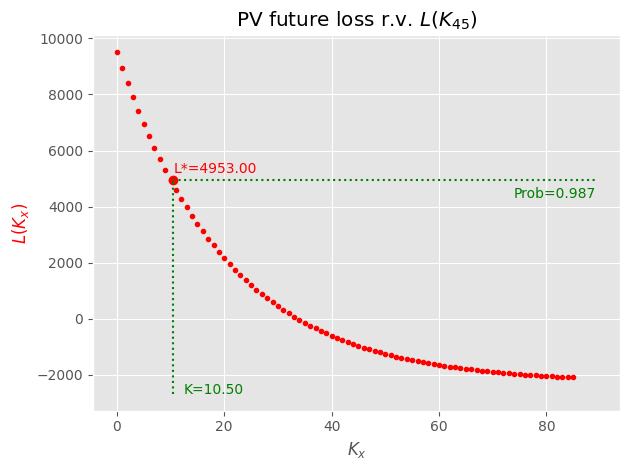

In [69]:
life = SULT().set_interest(i=0.05)
A = life.whole_life_insurance(45)
contract = Contract(benefit=10000, initial_premium=.8, renewal_premium=.1)
def fun(P):   # Solve for premium, given Loss(t=0) = 4953
    return life.L_from_t(t=10.5, contract=contract.set_contract(premium=P))
contract.set_contract(premium=life.solve(fun, target=4953, grid=100))
L = life.gross_policy_value(45, contract=contract)
life.L_plot(x=45, T=10.5, contract=contract)
isclose(-400, L, question="Q6.13")

__SOA Question 6.14  (D) 1150

For a special fully discrete whole life insurance of 100,000
on (40), you are given__ :

1. The annual net premium is *P* for years 1 through 10, 0.5*P* for
years 11 through 20, and 0 thereafter

2. Mortality follows the Standard Ultimate Life Table

3. *i* = 0.05

Calculate *P*.

In [70]:
life = SULT().set_interest(i=0.05)
a = life.temporary_annuity(40, t=10) + 0.5*life.deferred_annuity(40, u=10, t=10)
A = life.whole_life_insurance(40)
P = life.gross_premium(a=a, A=A, benefit=100000)
isclose(1150, P, question="Q6.14")

----- Q6.14 1150: 1148.5800555155263 [OK] -----


True

__SOA Question 6.15__ :  (B) 1.002

For a fully discrete whole life insurance of 1000 on (x) with net premiums payable quarterly, you are given:
1. $i = 0.05$
2. $\ddot{a}_x = 3.4611$
3. $P^{(W)}$ and $P^{(UDD)}$ are the annualized net premiums calculated using the 2-term Woolhouse (W) and the uniform distribution of deaths (UDD) assumptions,
respectively

Calculate $\dfrac{P^{(UDD)}}{P^{(W)}}$.


In [71]:
life = Recursion().set_interest(i=0.05).set_a(3.4611, x=0)
A = life.insurance_twin(3.4611)
udd = UDD(m=4, life=life)
a1 = udd.whole_life_annuity(x=x)
woolhouse = Woolhouse(m=4, life=life)
a2 = woolhouse.whole_life_annuity(x=x)
P = life.gross_premium(a=a1, A=A)/life.gross_premium(a=a2, A=A)
isclose(1.002, P, question="Q6.15")

----- Q6.15 1.002: 1.0022973504113772 [OK] -----


True

__SOA Question 6.16__ : (A) 2408.6

For a fully discrete 20-year endowment insurance of 100,000 on (30), you are given:
1. d = 0.05
2. Expenses, payable at the beginning of each year, are:

| | First Year | First Year | Renewal Years | Renewal Years |
| --- | --- | --- | --- | --- |
| | Percent of Premium | Per Policy | Percent of Premium | Per Policy |
| Taxes | 4% | 0 | 4% | 0  |
| Sales Commission | 35% | 0 | 2% | 0  |
| Policy Maintenance | 0% | 250 | 0% | 50  |

3. The net premium is 2143

Calculate the gross premium using the equivalence principle.



In [72]:
life = Premiums().set_interest(d=0.05)
A = life.insurance_equivalence(premium=2143, b=100000)
a = life.annuity_equivalence(premium=2143, b=100000)
p = life.gross_premium(A=A, a=a, benefit=100000, settlement_policy=0,
                       initial_policy=250, initial_premium=0.04 + 0.35,
                       renewal_policy=50, renewal_premium=0.04 + 0.02) 
isclose(2410, p, question="Q6.16")

----- Q6.16 2410: 2408.575206281868 [OK] -----


True

__SOA Question 6.17__ :  (A) -30000

An insurance company sells special fully discrete two-year endowment insurance policies to smokers (S) and non-smokers (NS) age x. You are given:

1. The death benefit is 100,000; the maturity benefit is 30,000
2. The level annual premium for non-smoker policies is determined by the
equivalence principle
3. The annual premium for smoker policies is twice the non-smoker annual premium
4. $\mu^{NS}_{x+t} = 0.1.\quad t > 0$
5. $q^S_{x+k} = 1.5 q_{x+k}^{NS}$, for $k = 0, 1$
6. $i = 0.08$

Calculate the expected present value of the loss at issue random variable on a smoker policy.


In [73]:
x = 0
life = ConstantForce(mu=0.1).set_interest(i=0.08)
A = life.endowment_insurance(x, t=2, b=100000, endowment=30000)
a = life.temporary_annuity(x, t=2)
P = life.gross_premium(a=a, A=A)
life1 = Recursion().set_interest(i=0.08)\
                   .set_q(life.q_x(x, t=1) * 1.5, x=x, t=1)\
                   .set_q(life.q_x(x+1, t=1) * 1.5, x=x+1, t=1)
contract = Contract(premium=P*2, benefit=100000, endowment=30000)
L = life1.gross_policy_value(x, t=0, n=2, contract=contract)
isclose(-30000, L, question="Q6.17")

 *Term Insurance A_0(t=2) <--
        a_4(t=1) = 1                                ~one-year discrete annuity
       A_0(t=1) = A_0(t=1,endow=1) - E_0(t=1)      ~endowment insurance - pure
       a_0(t=2) = 1 + E_0(t=1) * a_1(t=1)                  ~backward recursion
        a_1(t=1) = 1                                ~one-year discrete annuity
        a_-1(t=1) = 1                               ~one-year discrete annuity
    A_0(t=2,endow=1) = A_0(t=2) + E_0(t=2)           ~term plus pure endowment
        a_3(t=1) = 1                                ~one-year discrete annuity
        a_0(t=1) = 1                                ~one-year discrete annuity
     A_0(t=2) = A_0(t=2,endow=1) - E_0(t=2)        ~endowment insurance - pure
      E_0(t=2) = p_0(t=2) * v(t=2)                             ~pure endowment
       p_0(t=2) = p_1 * p_0                               ~survival chain rule
      A_0(t=2) = v * [ q_0 * b + p_0 * A_1(t=1) ]          ~backward recursion
       E_0(t=2) = E_0(

True

__SOA Question 6.18__ :  (D) 166400

For a 20-year deferred whole life annuity-due with annual
payments of 30,000 on (40), you are given:

1. The single net premium is refunded without interest at the end of
the year of death if death occurs during the deferral period

2. Mortality follows the Standard Ultimate Life Table

3.  *i* = 0.05 


Calculate the single net premium for this annuity.


In [74]:
life = SULT().set_interest(i=0.05)
def fun(P):
    A = (life.term_insurance(40, t=20, b=P)
         + life.deferred_annuity(40, u=20, b=30000))
    return life.gross_premium(a=1, A=A) - P
P = life.solve(fun, target=0, grid=[162000, 168800])
isclose(166400, P, question="Q6.18")

----- Q6.18 166400: 166362.83871487685 [OK] -----


True

__SOA Question 6.19__ :  (B) 0.033


In [75]:
life = SULT()
contract = Contract(initial_policy=.2, renewal_policy=.01)
a = life.whole_life_annuity(50)
A = life.whole_life_insurance(50)
contract.premium = life.gross_premium(A=A, a=a, **contract.premium_terms)
L = life.gross_policy_variance(50, contract=contract)
isclose(0.033, L, question="Q6.19")

----- Q6.19 0.033: 0.03283273381910885 [OK] -----


True

__SOA Question 6.20__ :  (B) 459

For a special fully discrete 3-year term insurance on (75), you are given:

1. The death benefit during the first two years is the sum of the net premiums paid
without interest

2. The death benefit in the third year is 10,000

| $x$ | $p_x$ |
|---|---|
| 75 | 0.90 |
| 76 | 0.88 |
| 77 | 0.85 |

3. $i = 0.04$

Calculate the annual net premium.


In [76]:
life = LifeTable().set_interest(i=.04).set_table(p={75: .9, 76: .88, 77: .85})
a = life.temporary_annuity(75, t=3)
IA = life.increasing_insurance(75, t=2)
A = life.deferred_insurance(75, u=2, t=1)
def fun(P): return life.gross_premium(a=a, A=P*IA + A*10000) - P
P = life.solve(fun, target=0, grid=[449, 489])
isclose(459, P, question="Q6.20")

----- Q6.20 459: 458.83181728297353 [OK] -----


True

__SOA Question 6.21__ :  (C) 100


In [77]:
life = Recursion(verbose=False).set_interest(d=0.04)
life.set_A(0.7, x=75, t=15, endowment=1)
life.set_E(0.11, x=75, t=15)
def fun(P):
    return (P * life.temporary_annuity(75, t=15) -
            life.endowment_insurance(75, t=15, b=1000, endowment=15*float(P)))
P = life.solve(fun, target=0, grid=(80, 120))
isclose(100, P, question="Q6.21")

----- Q6.21 100: 100.85470085470084 [OK] -----


True

__SOA Question 6.22__ :  (C) 102

For a whole life insurance of 100,000 on (45) with premiums payable monthly for a
period of 20 years, you are given:
1. The death benefit is paid immediately upon death
2. Mortality follows the Standard Ultimate Life Table
3. Deaths are uniformly distributed over each year of age
4. $i = 0.05$

Calculate the monthly net premium.


In [78]:
life=SULT(udd=True)
a = UDD(m=12, life=life).temporary_annuity(45, t=20)
A = UDD(m=0, life=life).whole_life_insurance(45)
P = life.gross_premium(A=A, a=a, benefit=100000) / 12
isclose(102, P, question="Q6.22")

----- Q6.22 102: 102.40668704849178 [OK] -----


True

__SOA Question 6.23__ :  (D) 44.7


In [79]:
x = 0
life = Recursion().set_a(15.3926, x=x)\
                  .set_a(10.1329, x=x, t=15)\
                  .set_a(14.0145, x=x, t=30)
def fun(P):
    per_policy = 30 + (30 * life.whole_life_annuity(x))
    per_premium = (0.6 + 0.1*life.temporary_annuity(x, t=15)
                    + 0.1*life.temporary_annuity(x, t=30))
    a = life.temporary_annuity(x, t=30)
    return (P * a) - (per_policy + per_premium * P)
P = life.solve(fun, target=0, grid=[30.3, 49.5])
isclose(44.7, P, question="Q6.23")


----- Q6.23 44.7: 44.70806635781144 [OK] -----


True

__SOA Question 6.24__ :  (E) 0.30

For a fully continuous whole life insurance of 1 on (x), you are given:

1. L is the present value of the loss at issue random variable if the premium rate is
determined by the equivalence principle
2. L^* is the present value of the loss at issue random variable if the premium rate is 0.06
3. $\delta = 0.07$
4. $\overline{A}_x = 0.30$
5. $Var(L) = 0.18$

Calculate $Var(L^*)$.


In [80]:
life = PolicyValues().set_interest(delta=0.07)
x, A1 = 0, 0.30   # Policy for first insurance
P = life.premium_equivalence(A=A1, discrete=False)  # Need its premium
contract = Contract(premium=P, discrete=False)
def fun(A2):  # Solve for A2, given Var(Loss)
    return life.gross_variance_loss(A1=A1, A2=A2, contract=contract)
A2 = life.solve(fun, target=0.18, grid=0.18)

contract = Contract(premium=0.06, discrete=False) # Solve second insurance
var = life.gross_variance_loss(A1=A1, A2=A2, contract=contract)
isclose(0.304, var, question="Q6.24")

----- Q6.24 0.304: 0.30419999999999975 [OK] -----


True

__SOA Question 6.25__ :  (C) 12330

For a fully discrete 10-year deferred whole life annuity-due of 1000 per month on (55), you are given:
1. The premium, $G$, will be paid annually at the beginning of each year during the deferral period
2. Expenses are expected to be 300 per year for all years, payable at the beginning of the year
3. Mortality follows the Standard Ultimate Life Table
4. $i = 0.05$
5. Using the two-term Woolhouse approximation, the expected loss at issue is -800

Calculate $G$.


In [81]:
life = SULT()
woolhouse = Woolhouse(m=12, life=life)
benefits = woolhouse.deferred_annuity(55, u=10, b=1000 * 12)
expenses = life.whole_life_annuity(55, b=300)
payments = life.temporary_annuity(55, t=10)
def fun(P):
    return life.gross_future_loss(A=benefits + expenses, a=payments,
                                  contract=Contract(premium=P))
P = life.solve(fun, target=-800, grid=[12110, 12550])
isclose(12330, P, question="Q6.25")

----- Q6.25 12330: 12325.781125438532 [OK] -----


True

__SOA Question 6.26  (D) 180

For a special fully discrete whole life insurance policy of
1000 on (90), you are given__ :

1. The first year premium is 0

2. *P* is the renewal premium

3. Mortality follows the Standard Ultimate Life Table

4. *i* = 0.05

5. Premiums are calculated using the equivalence principle

Calculate *P*.


In [82]:
life = SULT().set_interest(i=0.05)
def fun(P): 
    return P - life.net_premium(90, b=1000, initial_cost=P)
P = life.solve(fun, target=0, grid=[150, 190])
isclose(180, P, question="Q6.26")

----- Q6.26 180: 180.03164891315885 [OK] -----


True

__SOA Question 6.27__ :  (D) 10310

For a special fully continuous whole life insurance on (x), you are given:

1. Premiums and benefits:

| | First 20 years | After 20 years |
| --- | --- | --- |
| Premium Rate | 3P | P |
| Benefit | 1,000,000 | 500,000 |


2. $\mu_{x+t} = 0.03, \quad t \ge 0$
3. $\delta = 0.06$

Calculate $P$ using the equivalence principle.

In [83]:
life = ConstantForce(mu=0.03).set_interest(delta=0.06)
x = 0
payments = (3 * life.temporary_annuity(x, t=20, discrete=False) 
            + life.deferred_annuity(x, u=20, discrete=False))
benefits = (1000000 * life.term_insurance(x, t=20, discrete=False)
            + 500000 * life.deferred_insurance(x, u=20, discrete=False))
P = benefits / payments
isclose(10310, P, question="Q6.27")

----- Q6.27 10310: 10309.617799001708 [OK] -----


True

__SOA Question 6.28__ :  (B) 36


In [84]:
life = SULT().set_interest(i=0.05)
a = life.temporary_annuity(40, t=5)
A = life.whole_life_insurance(40)
P = life.gross_premium(a=a, A=A, benefit=1000, 
                       initial_policy=10, renewal_premium=.05,
                       renewal_policy=5, initial_premium=.2)
isclose(36, P, question="Q6.28")

----- Q6.28 36: 35.72634219391481 [OK] -----


True

__SOA Question 6.29  (B) 20.5


(35) purchases a fully discrete whole life insurance policy of 100,000.
You are given__ :
1. The annual gross premium, calculated using the equivalence principle, is 1770
2. The expenses in policy year 1 are 50% of premium and 200 per policy
3. The expenses in policy years 2 and later are 10% of premium and 50 per policy
4. All expenses are incurred at the beginning of the policy year
5. $i = 0.035$

Calculate $\ddot{a}_{35}$.

In [85]:
life = Premiums().set_interest(i=0.035)
def fun(a):
    return life.gross_premium(A=life.insurance_twin(a=a), a=a, 
                              initial_policy=200, initial_premium=.5,
                              renewal_policy=50, renewal_premium=.1,
                              benefit=100000)
a = life.solve(fun, target=1770, grid=[20, 22])
isclose(20.5, a, question="Q6.29")

----- Q6.29 20.5: 20.480268314431726 [OK] -----


True

__SOA Question 6.30__ :  (A) 900

For a fully discrete whole life insurance of 100 on (x), you are given:
1. The first year expense is 10% of the gross annual premium
2. Expenses in subsequent years are 5% of the gross annual premium
3. The gross premium calculated using the equivalence principle is 2.338
4. $i = 0.04$
5. $\ddot{a}_x = 16.50$
6. $^2A_x = 0.17$

Calculate the variance of the loss at issue random variable.


In [86]:
life = PolicyValues().set_interest(i=0.04)
contract = Contract(premium=2.338,
                    benefit=100,
                    initial_premium=.1,
                    renewal_premium=0.05)
var = life.gross_variance_loss(A1=life.insurance_twin(16.50),
                               A2=0.17, contract=contract)
isclose(900, var, question="Q6.30")

----- Q6.30 900: 908.141412994607 [OK] -----


True

__SOA Question 6.31__ :  (D) 1330


For a fully continuous whole life insurance policy of 100,000 on (35), you are given:
1. The density function of the future lifetime of a newborn:
$$\begin{align*}
f(t) & = 0.01 e^{-0.01 t}, \quad 0 \le t < 70\\
& = g(t), \quad t \ge 70
\end{align*}$$

2. $\delta = 0.05$

3. $\overline{A}_{70} = 0.51791$

Calculate the annual net premium rate for this policy.

In [87]:
life = ConstantForce(mu=0.01).set_interest(delta=0.05)
A = (life.term_insurance(35, t=35, discrete=False) 
     + life.E_x(35, t=35)*0.51791)     # A_35
P = life.premium_equivalence(A=A, b=100000, discrete=False)
isclose(1330, P, question="Q6.31")

----- Q6.31 1330: 1326.5406293909457 [OK] -----


True

__SOA Question 6.32__ :  (C) 550

For a whole life insurance of 100,000 on (x), you are given:
1. Death benefits are payable at the moment of death
2. Deaths are uniformly distributed over each year of age
3. Premiums are payable monthly
4. $i = 0.05$
5. $\ddot{a}_x = 9.19$

Calculate the monthly net premium.


In [88]:
x = 0
life = Recursion().set_interest(i=0.05).set_a(9.19, x=x)
benefits = UDD(m=0, life=life).whole_life_insurance(x)
payments = UDD(m=12, life=life).whole_life_annuity(x)
P = life.gross_premium(a=payments, A=benefits, benefit=100000)/12
isclose(550, P, question="Q6.32")

 *Whole Life Insurance A_0(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
        a_-3(t=1) = 1                               ~one-year discrete annuity
        a_4(t=1) = 1                                ~one-year discrete annuity
        a_-2(t=1) = 1                               ~one-year discrete annuity
        a_3(t=1) = 1                                ~one-year discrete annuity
        a_-1(t=1) = 1                               ~one-year discrete annuity
        a_2(t=1) = 1                                ~one-year discrete annuity
        a_0(t=1) = 1                                ~one-year discrete annuity
        a_1(t=1) = 1                                ~one-year discrete annuity
----- Q6.32 550: 550.4356936711871 [OK] -----


True

__SOA Question 6.33__ :  (B) 0.13


An insurance company sells 15-year pure endowments of 10,000 to 500 lives, each age x, with independent future lifetimes. The single premium for each pure endowment is determined by the equivalence principle.

You are given:
1. $i$ = 0.03
2. $\mu_x(t) = 0.02 t, \quad t \ge 0$
3. $_0L$ is the aggregate loss at issue random variable for these pure endowments.

Using the normal approximation without continuity correction, calculate $Pr(_0L) > 50,000)$.

In [89]:
life = Insurance().set_survival(mu=lambda x,t: 0.02*t).set_interest(i=0.03)
x = 0
var = life.E_x(x, t=15, moment=life.VARIANCE, endowment=10000)
p = 1- life.portfolio_cdf(mean=0, variance=var, value=50000, N=500)
isclose(0.13, p, question="Q6.33", rel_tol=0.02)

----- Q6.33 0.13: 0.12828940905648634 [OK] -----


True

__SOA Question 6.34__ :  (A) 23300

For a fully discrete whole life insurance policy on (61), you
are given:

1. The annual gross premium using the equivalence principle is 500

2. Initial expenses, incurred at policy issue, are 15% of the
 premium

3. Renewal expenses, incurred at the beginning of each year after
the first, are 3% of the premium

4. Mortality follows the Standard Ultimate Life Table

5. *i* = 0.05

Calculate the amount of the death benefit.


In [90]:
life = SULT()
def fun(benefit):
    A = life.whole_life_insurance(61)
    a = life.whole_life_annuity(61)
    return life.gross_premium(A=A, a=a, benefit=benefit, 
                              initial_premium=0.15, renewal_premium=0.03)
b = life.solve(fun, target=500, grid=[23300, 23700])
isclose(23300, b, question="Q6.34")

----- Q6.34 23300: 23294.288659265632 [OK] -----


True

__SOA Question 6.35__ :  (D) 530

For a fully discrete whole life insurance policy of 100,000 on (35), you are given:
1. First year commissions are 19% of the annual gross premium
2. Renewal year commissions are 4% of the annual gross premium
3. Mortality follows the Standard Ultimate Life Table
4. $i = 0.05$

Calculate the annual gross premium for this policy using the equivalence principle.


In [91]:
sult = SULT()
A = sult.whole_life_insurance(35, b=100000)
a = sult.whole_life_annuity(35)
P = sult.gross_premium(a=a, A=A, initial_premium=.19, renewal_premium=.04)
isclose(530, P, question="Q6.35")

----- Q6.35 530: 534.4072234303344 [OK] -----


True

__SOA Question 6.36__ :  (B) 500


In [92]:
life = ConstantForce(mu=0.04).set_interest(delta=0.08)
a = life.temporary_annuity(50, t=20, discrete=False)
A = life.term_insurance(50, t=20, discrete=False)
def fun(R):
    return life.gross_premium(a=a, A=A, initial_premium=R/4500,
                              renewal_premium=R/4500, benefit=100000)
R = life.solve(fun, target=4500, grid=[400, 800])
isclose(500, R, question="Q6.36")

----- Q6.36 500: 500.0 [OK] -----


True

__SOA Question 6.37__ :  (D) 820

For a fully discrete whole life insurance policy of 50,000 on (35), with premiums payable for a maximum of 10 years, you are given:

1. Expenses of 100 are payable at the end of each year including the year of death
2. Mortality follows the Standard Ultimate Life Table
3. $i = 0.05$

Calculate the annual gross premium using the equivalence principle.


In [93]:
sult = SULT()
benefits = sult.whole_life_insurance(35, b=50000 + 100)
expenses = sult.immediate_annuity(35, b=100)
a = sult.temporary_annuity(35, t=10)
P = (benefits + expenses) / a
isclose(820, P, question="Q6.37")

----- Q6.37 820: 819.7190338249138 [OK] -----


True

__SOA Question 6.38__ :  (B) 11.3

For an n-year endowment insurance of 1000 on (x), you are given:
1. Death benefits are payable at the moment of death
2. Premiums are payable annually at the beginning of each year
3. Deaths are uniformly distributed over each year of age
4. $i = 0.05$
5. $_nE_x = 0.172$
6. $\overline{A}_{x:\overline{n|}} = 0.192$

Calculate the annual net premium for this insurance.


In [94]:
x, n = 0, 10
life = Recursion().set_interest(i=0.05)\
                  .set_A(0.192, x=x, t=n, endowment=1, discrete=False)\
                  .set_E(0.172, x=x, t=n)
a = life.temporary_annuity(x, t=n, discrete=False)

def fun(a):   # solve for discrete annuity, given continuous
    life = Recursion(verbose=False).set_interest(i=0.05)
    life.set_a(a, x=x, t=n).set_E(0.172, x=x, t=n)
    return UDD(m=0, life=life).temporary_annuity(x, t=n)
a = life.solve(fun, target=a, grid=a)  # discrete annuity
P = life.gross_premium(a=a, A=0.192, benefit=1000)
isclose(11.3, P, question="Q6.38")

 *Temporary Annuity a_0(t=10) <--
   a_0(t=10) = [ 1 - A_0(t=10) ] / d(t=10)                       ~annuity twin
        a_-2(t=1) = 1                               ~one-year discrete annuity
        a_-1(t=1) = 1                               ~one-year discrete annuity
        a_0(t=1) = 1                                ~one-year discrete annuity
        a_1(t=1) = 1                                ~one-year discrete annuity
        a_2(t=1) = 1                                ~one-year discrete annuity
        a_3(t=1) = 1                                ~one-year discrete annuity
----- Q6.38 11.3: 11.308644185253657 [OK] -----


True

__SOA Question 6.39__ :  (A) 29

XYZ Insurance writes 10,000 fully discrete whole life insurance policies of 1000 on lives age 40 and an additional 10,000 fully discrete whole life policies of 1000 on lives age 80.

XYZ used the following assumptions to determine the net premiums for these policies:

1. Mortality follows the Standard Ultimate Life Table
2. i = 0.05

During the first ten years, mortality did follow the Standard Ultimate Life Table.

Calculate the average net premium per policy in force received at the beginning of the eleventh year.


In [95]:
sult = SULT()
P40 = sult.premium_equivalence(sult.whole_life_insurance(40), b=1000)
P80 = sult.premium_equivalence(sult.whole_life_insurance(80), b=1000)
p40 = sult.p_x(40, t=10)
p80 = sult.p_x(80, t=10)
P = (P40 * p40 + P80 * p80) / (p80 + p40)
isclose(29, P, question="Q6.39")

----- Q6.39 29: 29.033866427845496 [OK] -----


True

__SOA Question 6.40__ : (C) 116 

For a special fully discrete whole life insurance, you are given:

1. The death benefit is $1000(1.03)^k$ for death in policy year k, for $k = 1, 2, 3...$
2. $q_x = 0.05$
3. $i = 0.06$
4. $\ddot{a}_{x+1} = 7.00$
5. The annual net premium for this insurance at issue age x is 110

Calculate the annual net premium for this insurance at issue age $x + 1$.


In [96]:
# - standard formula discounts/accumulates by too much (i should be smaller)
x = 0
life = Recursion().set_interest(i=0.06).set_a(7, x=x+1).set_q(0.05, x=x)
a = life.whole_life_annuity(x)
A = 110 * a / 1000
life = Recursion().set_interest(i=0.06).set_A(A, x=x).set_q(0.05, x=x)
A1 = life.whole_life_insurance(x+1)
P = life.gross_premium(A=A1 / 1.03, a=7) * 1000
isclose(116, P, question="Q6.40")

 *Whole Life Annuity a_0(t=WL) <--
   a_0(t=WL) = 1 + E_0(t=1) * a_1(t=WL)                    ~backward recursion
    E_0(t=1) = p_0 * v(t=1)                                    ~pure endowment
     p_0 = 1 - q_0                                    ~complement of mortality
 *Whole Life Insurance A_1(t=WL) <--
     A_1(t=WL) = A_1(t=WL,endow=1) - E_1(t=WL)     ~endowment insurance - pure
      A_1(t=WL,endow=1) = A_1(t=WL) + E_1(t=WL)      ~term plus pure endowment
       A_1(t=WL) = [ A_0(t=WL) /v - q_1 * b ] / p_1         ~forward recursion
        p_0 = 1 - q_0                                 ~complement of mortality
----- Q6.40 116: 116.51945397474269 [OK] -----


True

__SOA Question 6.41__ :  (B) 1417


For a special fully discrete 2-year term insurance on (x), you are given:
1. $q_x = 0.01$
2. $q_{x + 1} = 0.02$
3. $i = 0.05$
4. The death benefit in the first year is 100,000
5. Both the benefits and premiums increase by 1% in the second year

Calculate the annual net premium in the first year.

In [97]:
x = 0
life = LifeTable().set_interest(i=0.05).set_table(q={x:.01, x+1:.02})
a = 1 + life.E_x(x, t=1) * 1.01
A = life.deferred_insurance(x, u=0, t=1) + 1.01*life.deferred_insurance(x, u=1, t=1)
P = 100000 * A / a
isclose(1417, P, question="Q6.41")

----- Q6.41 1417: 1416.9332301924137 [OK] -----


True

__SOA Question 6.42__ :  (D) 0.113


In [98]:
x = 0
life = ConstantForce(mu=0.06).set_interest(delta=0.06)
contract = Contract(discrete=True, premium=315.8, 
                    T=3, endowment=1000, benefit=1000)
L = [life.L_from_t(t, contract=contract) for t in range(3)]    # L(t)
Q = [life.q_x(x, u=u, t=1) for u in range(3)]              # prob(die in year t)
Q[-1] = 1 - sum(Q[:-1])   # follows SOA Solution: incorrectly treats endowment!
p = sum([q for (q, l) in zip (Q, L) if l > 0])
isclose(0.113, p, question="Q6.42")

----- Q6.42 0.113: 0.11307956328284252 [OK] -----


True

__SOA Question 6.43__ :  (C) 170

For a fully discrete, 5-payment 10-year term insurance of 200,000 on (30), you are given:
1. Mortality follows the Standard Ultimate Life Table
2. The following expenses are incurred at the beginning of each respective year:

| | Percent of Premium | Per Policy | Percent of Premium | Per Policy |
|---|---|---|---|---|
| | Year 1 | Year 1 | Years 2 - 10 | Years 2 - 10 |
| Taxes | 5% | 0 | 5% | 0 |
| Commissions | 30% | 0 | 10% | 0 |
| Maintenance | 0% | 8 | 0% | 4 |

3. i = 0.05
4. $\ddot{a}_{30:\overline{5|}} = 4.5431$

Calculate the annual gross premium using the equivalence principle.

- although 10-year term, premiums only paid first first years: separately calculate the EPV of per-policy maintenance expenses in years 6-10 and treat as additional initial expense

In [99]:
sult = SULT()
a = sult.temporary_annuity(30, t=5)
A = sult.term_insurance(30, t=10)
other_expenses = 4 * sult.deferred_annuity(30, u=5, t=5)
P = sult.gross_premium(a=a, A=A, benefit=200000, initial_premium=0.35,
                       initial_policy=8 + other_expenses, renewal_policy=4,
                       renewal_premium=0.15)
isclose(170, P, question="Q6.43")

----- Q6.43 170: 171.22371939459944 [OK] -----


True

__SOA Question 6.44__ :  (D) 2.18


In [100]:
life = Recursion().set_interest(i=0.05)\
                  .set_IA(0.15, x=50, t=10)\
                  .set_a(17, x=50)\
                  .set_a(15, x=60)\
                  .set_E(0.6, x=50, t=10)
A = life.deferred_insurance(50, u=10)
IA = life.increasing_insurance(50, t=10)
a = life.temporary_annuity(50, t=10)
P = life.gross_premium(a=a, A=A, IA=IA, benefit=100)
isclose(2.2, P, question="Q6.44")

 *Whole Life Insurance A_60(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
        a_57(t=1) = 1                               ~one-year discrete annuity
        a_64(t=1) = 1                               ~one-year discrete annuity
        a_58(t=1) = 1                               ~one-year discrete annuity
        a_63(t=1) = 1                               ~one-year discrete annuity
        a_59(t=1) = 1                               ~one-year discrete annuity
        a_62(t=1) = 1                               ~one-year discrete annuity
        a_60(t=1) = 1                               ~one-year discrete annuity
        a_61(t=1) = 1                               ~one-year discrete annuity
 *Whole Life Insurance A_60(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
        a_57(t=1) = 1                               ~one-year discrete annuity
        a_64(t=1) = 1                               ~on

True

__SOA Question 6.45__ :  (E) 690

For a fully continuous whole life insurance of 100,000 on
(35), you are given:

1. The annual rate of premium is 560

2. Mortality follows the Standard Ultimate Life Table

3. Deaths are uniformly distributed over each year of age

4. *i* = 0.05

Calculate the 75th percentile of the loss at issue random variable for
this policy.


----- Q6.45 690: 689.2659416264196 [OK] -----


True

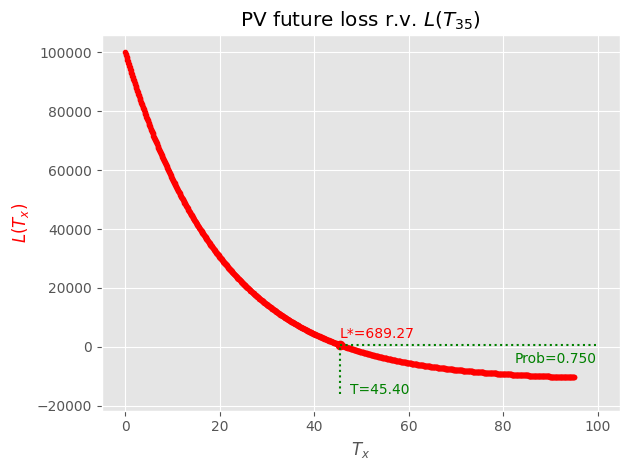

In [101]:
life = SULT(udd=True)
contract = Contract(benefit=100000, premium=560, discrete=False)
L = life.L_from_prob(x=35, prob=0.75, contract=contract)
life.L_plot(x=35, contract=contract, 
            T=life.L_to_t(L=L, contract=contract))
isclose(690, L, question="Q6.45")

__SOA Question 6.46__ :  (E) 208


In [102]:
life = Recursion().set_interest(i=0.05)\
                  .set_IA(0.51213, x=55, t=10)\
                  .set_a(12.2758, x=55)\
                  .set_a(7.4575, x=55, t=10)
A = life.deferred_annuity(55, u=10)
IA = life.increasing_insurance(55, t=10)
a = life.temporary_annuity(55, t=10)
P = life.gross_premium(a=a, A=A, IA=IA, benefit=300)
isclose(208, P, question="Q6.46")

 *Deferred Annuity a_55(t=WL,u=10) <--
        a_53(t=1) = 1                               ~one-year discrete annuity
        a_54(t=1) = 1                               ~one-year discrete annuity
        a_55(t=1) = 1                               ~one-year discrete annuity
        a_56(t=1) = 1                               ~one-year discrete annuity
        a_57(t=1) = 1                               ~one-year discrete annuity
        a_58(t=1) = 1                               ~one-year discrete annuity
----- Q6.46 208: 208.12282139036515 [OK] -----


True

__SOA Question 6.47__ :  (D) 66400

For a 10-year deferred whole life annuity-due with payments of 100,000 per year on (70), you are given:
1. Annual gross premiums of $G$ are payable for 10 years
2. First year expenses are 75% of premium
3. Renewal expenses for years 2 and later are 5% of premium during the premium paying period
4. Mortality follows the Standard Ultimate Life Table
5. i = 0.05

Calculate $G$ using the equivalence principle.


In [103]:
sult = SULT()
a = sult.temporary_annuity(70, t=10)
A = sult.deferred_annuity(70, u=10)
P = sult.gross_premium(a=a, A=A, benefit=100000, initial_premium=0.75,
                        renewal_premium=0.05)
isclose(66400, P, question="Q6.47")

----- Q6.47 66400: 66384.13293704337 [OK] -----


True

__SOA Question 6.48__ :  (A) 3195

For a special fully discrete 5-year deferred 3-year term insurance of 100,000 on (x) you are given:
1. There are two premium payments, each equal to P . The first is paid at the beginning of the first year and the second is paid at the end of the 5-year deferral period
2. $p_x = 0.95$
3. $q_{x + 5} = 0.02$
4. $q_{x + 6} = 0.03$
5. $q_{x + 7} = 0.04$
6. $i = 0.06$

Calculate P using the equivalence principle.


In [104]:
x = 0
life = Recursion().set_interest(i=0.06)\
                  .set_p(.95, x=x, t=5)\
                  .set_q(.02, x=x+5)\
                  .set_q(.03, x=x+6)\
                  .set_q(.04, x=x+7)
a = 1 + life.E_x(x, t=5)
A = life.deferred_insurance(x, u=5, t=3)
P = life.gross_premium(A=A, a=a, benefit=100000)
isclose(3195, P, question="Q6.48")

 *Pure Endowment E_0(t=5) <--
   E_0(t=5) = p_0(t=5) * v(t=5)                                ~pure endowment
 *Pure Endowment E_0(t=5) <--
   E_0(t=5) = p_0(t=5) * v(t=5)                                ~pure endowment
 *Term Insurance A_5(t=3) <--
        a_10(t=1) = 1                               ~one-year discrete annuity
       A_5(t=1) = A_5(t=1,endow=1) - E_5(t=1)      ~endowment insurance - pure
       a_5(t=2) = 1 + E_5(t=1) * a_6(t=1)                  ~backward recursion
        a_6(t=1) = 1                                ~one-year discrete annuity
        a_4(t=1) = 1                                ~one-year discrete annuity
    A_5(t=3,endow=1) = A_5(t=3) + E_5(t=3)           ~term plus pure endowment
     E_5(t=3) = p_5(t=3) * v(t=3)                              ~pure endowment
      p_5(t=3) = p_6(t=2) * p_5                           ~survival chain rule
       p_6(t=2) = p_7 * p_6                               ~survival chain rule
        a_9(t=1) = 1                     

True

__SOA Question 6.49__ :  (C) 86

For a special whole life insurance of 100,000 on (40), you are given:
1. The death benefit is payable at the moment of death
2. Level gross premiums are payable monthly for a maximum of 20 years
3. Mortality follows the Standard Ultimate Life Table
4. $i = 0.05$
5. Deaths are uniformly distributed over each year of age
6. Initial expenses are 200
7. Renewal expenses are 4% of each premium including the first
8. Gross premiums are calculated using the equivalence principle

Calculate the monthly gross premium.


In [105]:
sult = SULT(udd=True)
a = UDD(m=12, life=sult).temporary_annuity(40, t=20)
A = sult.whole_life_insurance(40, discrete=False)
P = sult.gross_premium(a=a, A=A, benefit=100000, initial_policy=200,
                       renewal_premium=0.04, initial_premium=0.04) / 12
isclose(86, P, question="Q6.49")

----- Q6.49 86: 85.99177833261696 [OK] -----


True

__SOA Question 6.50__ :  (A) -47000

On July 15, 2017, XYZ Corp buys fully discrete whole life
insurance policies of 1,000 on each
of its 10,000 workers, all age 35. It uses the death benefits to partially pay the premiums for the following year.

You are given:

1. Mortality follows the Standard Ultimate Life Table

2. *i* = 0.05

3. The insurance is priced using the equivalence principle

Calculate XYZ Corp's expected net cash flow from these policies during
July 2018.


In [106]:
life = SULT()
P = life.premium_equivalence(a=life.whole_life_annuity(35), b=1000) 
a = life.deferred_annuity(35, u=1, t=1)
A = life.term_insurance(35, t=1, b=1000)
cash = (A - a * P) * 10000 / life.interest.v
isclose(-47000, cash, question="Q6.50")

----- Q6.50 -47000: -46948.2187697819 [OK] -----


True

__SOA Question 6.51__ :  (D) 34700


In [107]:
life = Recursion().set_DA(0.4891, x=62, t=10)\
                   .set_A(0.0910, x=62, t=10)\
                   .set_a(12.2758, x=62)\
                   .set_a(7.4574, x=62, t=10)
IA = life.increasing_insurance(62, t=10)
A = life.deferred_annuity(62, u=10)
a = life.temporary_annuity(62, t=10)
P = life.gross_premium(a=a, A=A, IA=IA, benefit=50000)
isclose(34700, P, question="Q6.51")

 *Increasing Insurance IA_62(t=10) <--
   IA_62(t=10) = 11 A_62(t=10) - DA_62(t=10)       ~varying insurance identity
 *Deferred Annuity a_62(t=WL,u=10) <--
        a_60(t=1) = 1                               ~one-year discrete annuity
        a_61(t=1) = 1                               ~one-year discrete annuity
        a_62(t=1) = 1                               ~one-year discrete annuity
        a_63(t=1) = 1                               ~one-year discrete annuity
        a_64(t=1) = 1                               ~one-year discrete annuity
        a_65(t=1) = 1                               ~one-year discrete annuity
----- Q6.51 34700: 34687.207544453246 [OK] -----


True

__SOA Question 6.52__ :  (D) 50.80

For a fully discrete 10-payment whole life insurance of H on (45), you are given:
1. Expenses payable at the beginning of each year are as follows:

| Expense Type | First Year | Years 2-10 | Years 11+ |
|---|---|---|---|
| Per policy | 100 | 20 | 10 |
| % of Premium |105% | 5% | 0% |

2. Mortality follows the Standard Ultimate Life Table
3. i = 0.05
4. The gross annual premium, calculated using the equivalence principle, is of the form $G = gH + f$, where $g$ is the premium rate per 1 of insurance and $f$ is the per policy fee

Calculate $f$.

- set face value benefits to 0


In [108]:
sult = SULT()
a = sult.temporary_annuity(45, t=10)
other_cost = 10 * sult.deferred_annuity(45, u=10)
P = sult.gross_premium(a=a, A=0, benefit=0,    # set face value H = 0
                       initial_premium=1.05, renewal_premium=0.05,
                       initial_policy=100 + other_cost, renewal_policy=20)
isclose(50.8, P, question="Q6.52")

----- Q6.52 50.8: 50.80135534704229 [OK] -----


True

__SOA Question 6.53__ :  (D) 720

A warranty pays 2000 at the end of the year of the first failure if a washing machine fails within
three years of purchase. The warranty is purchased with a single premium, G, paid at the time of
purchase of the washing machine.
You are given:
1. 10% of the washing machines that are working at the start of each year fail by the end of that year
2. *i* = 0.08
3. The sales commission is 35% of G
4. G is calculated using the equivalence principle

Calculate G.



In [109]:
x = 0
life = LifeTable().set_interest(i=0.08).set_table(q={x:.1, x+1:.1, x+2:.1})
A = life.term_insurance(x, t=3)
P = life.gross_premium(a=1, A=A, benefit=2000, initial_premium=0.35)
isclose(720, P, question="Q6.53")

----- Q6.53 720: 720.1646090534978 [OK] -----


True

__SOA Question 6.54__ :  (A) 25440

For a fully discrete whole life insurance of 200,000 on (45),
you are given:

1. Mortality follows the Standard Ultimate Life Table.

2. *i* = 0.05

3. The annual premium is determined using the equivalencep rinciple.

Calculate the standard deviation of
$_0L$ , the present value random variable for the loss at issue. 

[A modified version of Question 12 on the Fall 2017 exam]


In [110]:
life = SULT()
std = math.sqrt(life.net_policy_variance(45, b=200000))
isclose(25440, std, question="Q6.54")

----- Q6.54 25440: 25441.694847703857 [OK] -----


True

## 7 Policy Values

__SOA Question 7.1__ :  (C) 11150

For a special fully discrete whole life insurance on (40), you
are given:

1. The death benefit is 50,000 in the first 20 years and 100,000
 thereafter

2. Level net premiums of 875 are payable for 20 years

3. Mortality follows the Standard Ultimate Life Table

4. *i* = 0.05

 Calculate $_{10}V$ the net premium policy value at the end of year 10
 for this insurance.


In [111]:
life = SULT()
x, n, t = 40, 20, 10
A = (life.whole_life_insurance(x+t, b=50000)
     + life.deferred_insurance(x+t, u=n-t, b=50000))
a = life.temporary_annuity(x+t, t=n-t, b=875)
L = life.gross_future_loss(A=A, a=a)
isclose(11150, L, question="Q7.1")

----- Q7.1 11150: 11152.108749338717 [OK] -----


True

__SOA Question 7.2__ :  (C) 1152


In [112]:
x = 0
life = Recursion(verbose=False).set_interest(i=.1)\
                               .set_q(0.15, x=x)\
                               .set_q(0.165, x=x+1)\
                               .set_reserves(T=2, endowment=2000)

def fun(P):  # solve P s.t. V is equal backwards and forwards
    policy = dict(t=1, premium=P, benefit=lambda t: 2000, reserve_benefit=True)
    return life.t_V_backward(x, **policy) - life.t_V_forward(x, **policy)
P = life.solve(fun, target=0, grid=[1070, 1230])
isclose(1152, P, question="Q7.2")

----- Q7.2 1152: 1151.5151515151515 [OK] -----


True

__SOA Question 7.3__ :  (E) 730


In [113]:
x = 0  # x=0 is (90) and interpret every 3 months as t=1 year
life = LifeTable().set_interest(i=0.08/4)\
                  .set_table(l={0:1000, 1:898, 2:800, 3:706})\
                  .set_reserves(T=8, V={3: 753.72})
V = life.t_V_backward(x=0, t=2, premium=60*0.9, benefit=lambda t: 1000)
V = life.set_reserves(V={2: V})\
        .t_V_backward(x=0, t=1, premium=0, benefit=lambda t: 1000)
isclose(730, V, question="Q7.3")

----- Q7.3 730: 729.998398765594 [OK] -----


True

__SOA Question 7.4__ :  (B) -74 

For a special fully discrete whole life insurance on (40), you
are given:

1. The death benefit is 1000 during the first 11 years and 5000
 thereafter

2. Expenses, payable at the beginning of the year, are 100 in year
 1 and 10 in years 2 and later

3. $\pi$ is the level annual premium, determined using the
 equivalence principle

4. $G = 1.02 \times \pi$ is the level annual gross premium

5. Mortality follows the Standard Ultimate Life Table

6. *i* = 0.05

7. $_{11}E_{40} = 0.57949$

 Calculate the gross premium policy value at the end of year 1 for this
 insurance.

 *hints:*

- split benefits into two policies


In [114]:
life = SULT()
P = life.gross_premium(a=life.whole_life_annuity(40),
                       A=life.whole_life_insurance(40),
                       initial_policy=100, renewal_policy=10,
                       benefit=1000)
P += life.gross_premium(a=life.whole_life_annuity(40),
                        A=life.deferred_insurance(40, u=11),
                        benefit=4000)   # for deferred portion
contract = Contract(benefit=1000, premium=1.02*P, 
                    renewal_policy=10, initial_policy=100)
V = life.gross_policy_value(x=40, t=1, contract=contract)
contract = Contract(benefit=4000, premium=0)  
A = life.deferred_insurance(41, u=10)
V += life.gross_future_loss(A=A, a=0, contract=contract)   # for deferred portion
isclose(-74, V, question="Q7.4")

----- Q7.4 -74: -73.942155695248 [OK] -----


True

__SOA Question 7.5__ :  (E) 1900

For a fully discrete whole life insurance of 10,000 on (*x*),
you are given:

1. Deaths are uniformly distributed over each year of age

2. The net premium is 647.46

3. The net premium policy value at the end of year 4 is 1405.08

4. $q_{x+4}$ = 0.04561

5. *i* = 0.03

 Calculate the net premium policy value at the end of 4.5 years.



In [115]:
x = 0
life = Recursion(udd=True).set_interest(i=0.03)\
                          .set_q(0.04561, x=x+4)\
                          .set_reserves(T=3, V={4: 1405.08})
V = life.r_V_forward(x, s=4, r=0.5, benefit=10000, premium=647.46)
isclose(1900, V, question="Q7.5")

----- Q7.5 1900: 1901.766021537228 [OK] -----


True

Answer 7.6:  (E) -25.4


In [116]:
life = SULT()
P = life.net_premium(45, b=2000)
contract = Contract(benefit=2000, initial_premium=.25, renewal_premium=.05,
                    initial_policy=2*1.5 + 30, renewal_policy=2*.5 + 10)
G = life.gross_premium(a=life.whole_life_annuity(45), **contract.premium_terms)
gross = life.gross_policy_value(45, t=10, contract=contract.set_contract(premium=G))
net = life.net_policy_value(45, t=10, b=2000)
V = gross - net
isclose(-25.4, V, question="Q7.6")    

----- Q7.6 -25.4: -25.44920289521204 [OK] -----


True

__SOA Question 7.7__ :  (D) 1110

For a whole life insurance of 10,000 on (x), you are given:
1. Death benefits are payable at the end of the year of death
2. A premium of 30 is payable at the start of each month
3. Commissions are 5% of each premium
4. Expenses of 100 are payable at the start of each year
5. $i = 0.05$
6. $1000 A_{x+10} = 400$
7. $_{10} V$ is the gross premium policy value at the end of year 10 for this insurance

Calculate $_{10} V$ using the two-term Woolhouse formula for annuities.


In [117]:
x = 0
life = Recursion().set_interest(i=0.05).set_A(0.4, x=x+10)
a = Woolhouse(m=12, life=life).whole_life_annuity(x+10)
contract = Contract(premium=0, benefit=10000, renewal_policy=100)
V = life.gross_future_loss(A=0.4, contract=contract.renewals())
contract = Contract(premium=30*12, renewal_premium=0.05)
V += life.gross_future_loss(a=a, contract=contract.renewals())
isclose(1110, V, question="Q7.7")

 *Whole Life Annuity a_10(t=WL) <--
   a_x = (1-A_x) / d                                           ~insurance twin
        a_8(t=1) = 1                                ~one-year discrete annuity
        a_9(t=1) = 1                                ~one-year discrete annuity
        a_10(t=1) = 1                               ~one-year discrete annuity
        a_11(t=1) = 1                               ~one-year discrete annuity
        a_12(t=1) = 1                               ~one-year discrete annuity
        a_13(t=1) = 1                               ~one-year discrete annuity
----- Q7.7 1110: 1107.9718253968258 [OK] -----


True

__SOA Question 7.8__ :  (C) 29.85


In [118]:
sult = SULT()
x = 70
q = {x: [sult.q_x(x+k)*(.7 + .1*k) for k in range(3)] + [sult.q_x(x+3)]}
life = Recursion().set_interest(i=.05)\
                  .set_q(sult.q_x(70)*.7, x=x)\
                  .set_reserves(T=3)
V = life.t_V(x=70, t=1, premium=35.168, benefit=lambda t: 1000)
isclose(29.85, V, question="Q7.8")

 *Survival p_70 <--
   p_70 = 1 - q_70                                    ~complement of mortality
----- Q7.8 29.85: 29.85469179271202 [OK] -----


True

__SOA Question 7.9__ :  (A) 38100

For a semi-continuous 20-year endowment insurance of 100,000 on (45), you are given:
1. Net premiums of 253 are payable monthly
2. Mortality follows the Standard Ultimate Life Table
3. Deaths are uniformly distributed over each year of age
4. $i = 0.05$

Calculate $_{10}V$, the net premium policy value at the end of year 10 for this insurance.


In [119]:
sult = SULT(udd=True)
x, n, t = 45, 20, 10
a = UDD(m=12, life=sult).temporary_annuity(x+10, t=n-10)
A = UDD(m=0, life=sult).endowment_insurance(x+10, t=n-10)
contract = Contract(premium=253*12, endowment=100000, benefit=100000)
V = sult.gross_future_loss(A=A, a=a, contract=contract)
isclose(38100, V, question="Q7.9")

----- Q7.9 38100: 38099.62176709246 [OK] -----


True

__SOA Question 7.10__ : (C) -970

For a fully discrete whole life insurance of 100,000 on (45),
you are given:

1. Mortality follows the Standard Ultimate Life Table

2. *i* = 0.05

3. Commission expenses are 60% of the first year's gross premium
 and 2% of renewal gross premiums

4. Administrative expenses are 500 in the first year and 50 in
 each renewal year

5. All expenses are payable at the start of the year

6. The gross premium, calculated using the equivalence principle,
 is 977.60

 Calculate $_5V^e$, the expense reserve at the end of year 5 for this
 insurance.


In [120]:
life = SULT()
G = 977.6
P = life.net_premium(45, b=100000)
contract = Contract(benefit=0, premium=G-P, renewal_policy=.02*G + 50)
V = life.gross_policy_value(45, t=5, contract=contract)
isclose(-970, V, question="Q7.10")

----- Q7.10 -970: -971.8909301877826 [OK] -----


True

__SOA Question 7.11__ :  (B) 1460


In [121]:
life = Recursion().set_interest(i=0.05).set_a(13.4205, x=55)
contract = Contract(benefit=10000)
def fun(P):
    return life.L_from_t(t=10, contract=contract.set_contract(premium=P))
P = life.solve(fun, target=4450, grid=400)
V = life.gross_policy_value(45, t=10, contract=contract.set_contract(premium=P))
isclose(1460, V, question="Q7.11")

 *Whole Life Insurance A_55(t=WL) <--
   A_x = 1 - d * a_x                                             ~annuity twin
        a_52(t=1) = 1                               ~one-year discrete annuity
        a_59(t=1) = 1                               ~one-year discrete annuity
        a_53(t=1) = 1                               ~one-year discrete annuity
        a_58(t=1) = 1                               ~one-year discrete annuity
        a_54(t=1) = 1                               ~one-year discrete annuity
        a_57(t=1) = 1                               ~one-year discrete annuity
        a_55(t=1) = 1                               ~one-year discrete annuity
        a_56(t=1) = 1                               ~one-year discrete annuity
----- Q7.11 1460: 1459.9818035330218 [OK] -----


True

__SOA Question 7.12__ :  (E) 4.09

For a special fully discrete 25-year endowment insurance on
(44), you are given:

1. The death benefit is ( 26−*k* ) for death in year ,*k* for *k* =
 1,2,3,...,25

2. The endowment benefit in year 25 is 1

3. Net premiums are level

4. $q_{55}$= 0.15

5. *i* = 0.04

6. $_{11}V$ the net premium policy value at the end of year 11, is
 5.00

1. $_{24}V$ the net premium policy value at the end of year 24, is
 0.60

 Calculate $_{12}V$ the net premium policy value at end of year 12.


In [122]:
benefit = lambda k: 26 - k
x = 44
life = Recursion().set_interest(i=0.04)\
                  .set_q(0.15, x=55)\
                  .set_reserves(T=25, endowment=1, V={11: 5.})
def fun(P):  # solve for net premium, from final year recursion
    return life.t_V(x=x, t=24, premium=P, benefit=benefit)
P = life.solve(fun, target=0.6, grid=0.5)    # solved net premium
V = life.t_V(x, t=12, premium=P, benefit=benefit)  # recursion formula
isclose(4.09, V, question="Q7.12")

 *Survival p_55 <--
   p_55 = 1 - q_55                                    ~complement of mortality
----- Q7.12 4.09: 4.089411764705883 [OK] -----


True

Answer 7.13: (A) 180


In [123]:
life = SULT()
V = life.FPT_policy_value(40, t=10, n=30, endowment=1000, b=1000)
isclose(180, V, question="Q7.13")

----- Q7.13 180: 180.1071785904076 [OK] -----


True

__SOA Question 7.14__ :  (A) 2200

For a fully discrete whole life insurance of 100,000 on (45),
you are given:

1. The gross premium policy value at duration 5 is 5500 and at
 duration 6 is 7100

2. $q_{50}$ = 0.009

3. *i* = 0.05

4. Renewal expenses at the start of each year are 50 plus 4% of the gross premium.

5. Claim expenses are 200.

 Calculate the gross premium.



In [124]:
x = 45
life = Recursion(verbose=False).set_interest(i=0.05)\
                               .set_q(0.009, x=50)\
                               .set_reserves(T=10, V={5: 5500})
def fun(P):  # solve for net premium,
    return life.t_V(x=x, t=6, premium=P*0.96 - 50, benefit=lambda t: 100000+200)
P = life.solve(fun, target=7100, grid=[2200, 2400])
isclose(2200, P, question="Q7.14")

----- Q7.14 2200: 2197.8174603174602 [OK] -----


True

__SOA Question 7.15__ :  (E) 50.91

For a fully discrete whole life insurance of 100 on (*x*), you
are given:

1. $q_{x+ 15} = 0.10$

2. Deaths are uniformly distributed over each year of age

3. *i* = 0.05

4. $_tV$ denotes the net premium policy value at time *t*

5. $_{16}V$ = 49.78

 Calculate 15.6.


In [125]:
x = 0
V = Recursion(udd=True).set_interest(i=0.05)\
                       .set_q(0.1, x=x+15)\
                       .set_reserves(T=3, V={16: 49.78})\
                       .r_V_backward(x, s=15, r=0.6, benefit=100)
isclose(50.91, V, question="Q7.15")

----- Q7.15 50.91: 50.91362826922369 [OK] -----


True

__SOA Question 7.16__ :  (D) 380


In [126]:
life = SelectLife().set_interest(v=.95)\
                   .set_table(A={86: [683/1000]},
                              q={80+k: [.01*(k+1)] for k in range(6)})
x, t, n = 80, 3, 5
A = life.whole_life_insurance(x+t)
a = life.temporary_annuity(x+t, t=n-t)
V = life.gross_future_loss(A=A, a=a, contract=Contract(benefit=1000, premium=130))
isclose(380, V, question="Q7.16")

----- Q7.16 380: 381.6876905200001 [OK] -----


True

__SOA Question 7.17__ :  (D) 1.018


In [127]:
x = 0
life = Recursion().set_interest(v=math.sqrt(0.90703))\
                  .set_q(0.02067, x=x+10)\
                  .set_A(0.52536, x=x+11)\
                  .set_A(0.30783, x=x+11, moment=2)
A1 = life.whole_life_insurance(x+10)
A2 = life.whole_life_insurance(x+10, moment=2)
ratio = (life.insurance_variance(A2=A2, A1=A1) 
         / life.insurance_variance(A2=0.30783, A1=0.52536))
isclose(1.018, ratio, question="Q7.17")

 *Whole Life Insurance A_10(t=WL) <--
     A_10(t=WL) = A_10(t=WL,endow=1) - E_10(t=WL)     ~endowment insurance - pure
      A_10(t=WL,endow=1) = A_10(t=WL) + E_10(t=WL)     ~term plus pure endowment
       A_10(t=WL) = v * [ q_10 * b + p_10 * A_11(t=WL) ]     ~backward recursion
        p_10 = 1 - q_10                               ~complement of mortality
 *Whole Life Insurance A_10(t=WL,mom=2) <--
     A_10(t=WL,mom=2) = A_10(t=WL,endow=1,mom=2) - E_10(t=WL,mom=2)     ~endowment insurance - pure
      A_10(t=WL,endow=1,mom=2) = A_10(t=WL,mom=2) + E_10(t=WL,mom=2)     ~term plus pure endowment
       A_10(t=WL,mom=2) = v^2 * [ q_10 * b^2 + p_10 * A_11(t=WL,mom=2) ]     ~backward recursion
        p_10 = 1 - q_10                               ~complement of mortality
----- Q7.17 1.018: 1.0182465434445054 [OK] -----


True

__SOA Question 7.18__ :  (A) 17.1

For a fully discrete whole life insurance of 1 on (*x*), you
are given:

1. The net premium policy value at the end of the first year is 0.012

2. $q_x$ = 0.009

3. *i* = 0.04

Calculate $\ddot{a}_x$


In [128]:
x = 10
life = Recursion(verbose=False).set_interest(i=0.04).set_q(0.009, x=x)
def fun(a):
    return life.set_a(a, x=x).net_policy_value(x, t=1)
a = life.solve(fun, target=0.012, grid=[17.1, 19.1])
isclose(17.1, a, question="Q7.18")

----- Q7.18 17.1: 17.07941929974385 [OK] -----


True

__SOA Question 7.19__ :  (D) 720

 For a fully discrete whole life insurance of 100,000 on (40)
you are given:

1. Expenses incurred at the beginning of the first year are 300
 plus 50% of the first year premium

2. Renewal expenses, incurred at the beginning of the year, are
 10% of each of the renewal premiums

3. Mortality follows the Standard Ultimate Life Table

4. *i* = 0.05

5. Gross premiums are calculated using the equivalence principle

Calculate the gross premium policy value for this insurance immediately
after the second premium and associated renewal expenses are paid.


In [129]:
life = SULT()
contract = Contract(benefit=100000,
                    initial_policy=300,
                    initial_premium=.5,
                    renewal_premium=.1)
P = life.gross_premium(A=life.whole_life_insurance(40), **contract.premium_terms)
A = life.whole_life_insurance(41)
a = life.immediate_annuity(41)   # after premium and expenses are paid
V = life.gross_future_loss(A=A,
                           a=a,
                           contract=contract.set_contract(premium=P).renewals())
isclose(720, V, question="Q7.19")

----- Q7.19 720: 722.7510208759086 [OK] -----


True

__SOA Question 7.20__ : (E) -277.23

For a fully discrete whole life insurance of 1000 on (35), you
are given:

1. First year expenses are 30% of the gross premium plus 300

2. Renewal expenses are 4% of the gross premium plus 30

3. All expenses are incurred at the beginning of the policy year

4. Gross premiums are calculated using the equivalence principle

5. The gross premium policy value at the end of the first policy
 year is *R*

6. Using the Full Preliminary Term Method, the modified reserve at
 the end of the first policy year is *S*

7. Mortality follows the Standard Ultimate Life Table

8. *i* = 0.05

Calculate *R*−*S* .


In [130]:
life = SULT()
S = life.FPT_policy_value(35, t=1, b=1000)  # is 0 for FPT at t=0,1
contract = Contract(benefit=1000,
                    initial_premium=.3,
                    initial_policy=300,
                    renewal_premium=.04,
                    renewal_policy=30)
G = life.gross_premium(A=life.whole_life_insurance(35), **contract.premium_terms)
R = life.gross_policy_value(35, t=1, contract=contract.set_contract(premium=G))
isclose(-277.23, R - S, question="Q7.20")

----- Q7.20 -277.23: -277.19303323929216 [OK] -----


True

__SOA Question 7.21__ :  (D) 11866


In [131]:
life = SULT()
x, t, u = 55, 9, 10
P = life.gross_premium(IA=0.14743,
                       a=life.temporary_annuity(x, t=u),
                       A=life.deferred_annuity(x, u=u),
                       benefit=1000)
contract = Contract(initial_policy=life.term_insurance(x+t, t=1, b=10*P),
                    premium=P,
                    benefit=1000)
a = life.temporary_annuity(x+t, t=u-t)
A = life.deferred_annuity(x+t, u=u-t)
V = life.gross_future_loss(A=A, a=a, contract=contract)
isclose(11866, V, question="Q7.21")

----- Q7.21 11866: 11866.30158100453 [OK] -----


True

__SOA Question 7.22__ :  (C) 46.24


In [132]:
life = PolicyValues().set_interest(i=0.06)
contract = Contract(benefit=8, premium=1.250)
def fun(A2): 
    return life.gross_variance_loss(A1=0, A2=A2, contract=contract)
A2 = life.solve(fun, target=20.55, grid=20.55/8**2)
contract = Contract(benefit=12, premium=1.875)
var = life.gross_variance_loss(A1=0, A2=A2, contract=contract)
isclose(46.2, var, question="Q7.22")

----- Q7.22 46.2: 46.2375 [OK] -----


True

__SOA Question 7.23__ :  (D) 233


In [133]:
life = Recursion().set_interest(i=0.04).set_p(0.995, x=25)
A = life.term_insurance(25, t=1, b=10000)
def fun(beta):  # value of premiums in first 20 years must be equal
    return beta * 11.087 + (A - beta) 
beta = life.solve(fun, target=216 * 11.087, grid=[140, 260])
isclose(233, beta, question="Q7.23")

 *Term Insurance A_25(t=1,b=10000) <--
   A_25(t=1) = A_25(t=1,endow=10000) - E_25(t=1,endow=10000)     ~endowment insurance - pure
    E_25(t=1) = p_25 * v(t=1)                                  ~pure endowment
----- Q7.23 233: 232.64747466274176 [OK] -----


True

__SOA Question 7.24__ :  (C) 680

For a fully discrete whole life insurance policy of 1,000,000
on (50), you are given:

1. The annual gross premium, calculated using the equivalence
 principle, is 11,800

2. Mortality follows the Standard Ultimate Life Table

3. *i* = 0.05

 Calculate the expense loading, *P* for this policy.


In [134]:
life = SULT()
P = life.premium_equivalence(A=life.whole_life_insurance(50), b=1000000)
isclose(680, 11800 - P, question="Q7.24")

----- Q7.24 680: 680.291823645397 [OK] -----


True

__SOA Question 7.25__ :  (B) 3947.37


In [135]:
life = SelectLife().set_interest(i=.04)\
                   .set_table(A={55: [.23, .24, .25],
                                 56: [.25, .26, .27],
                                 57: [.27, .28, .29],
                                 58: [.20, .30, .31]})
V = life.FPT_policy_value(55, t=3, b=100000)
isclose(3950, V, question="Q7.25")

----- Q7.25 3950: 3947.3684210526353 [OK] -----


True

__SOA Question 7.26__ :  (D) 28540 
- backward = forward reserve recursion


In [136]:
x = 0
life = Recursion(verbose=False).set_interest(i=.05)\
                               .set_p(0.85, x=x)\
                               .set_p(0.85, x=x+1)\
                               .set_reserves(T=2, endowment=50000)
def benefit(k): return k * 25000
def fun(P):  # solve P s.t. V is equal backwards and forwards
    policy = dict(t=1, premium=P, benefit=benefit, reserve_benefit=True)
    return life.t_V_backward(x, **policy) - life.t_V_forward(x, **policy)
P = life.solve(fun, target=0, grid=[27650, 28730])
isclose(28540, P, question="Q7.26")

----- Q7.26 28540: 28542.392566782808 [OK] -----


True

__SOA Question 7.27__ :  (B) 213


In [137]:
x = 0
life = Recursion(verbose=False).set_interest(i=0.03)\
                               .set_q(0.008, x=x)\
                               .set_reserves(V={0: 0})
def fun(G):  # Solve gross premium from expense reserves equation
    return life.t_V(x=x, t=1, premium=G - 187, benefit=lambda t: 0,
                    per_policy=10 + 0.25*G)
G = life.solve(fun, target=-38.70, grid=[200, 252])
isclose(213, G, question="Q7.27")

----- Q7.27 213: 212.970355987055 [OK] -----


True

__SOA Question 7.28__ :  (D) 24.3


In [138]:
life = SULT()
PW = life.net_premium(65, b=1000)   # 20_V=0 => P+W is net premium for A_65
P = life.net_premium(45, t=20, b=1000)  # => P is net premium for A_45:20
isclose(24.3, PW - P, question="Q7.28")

----- Q7.28 24.3: 24.334725400123975 [OK] -----


True

__SOA Question 7.29__ :  (E) 2270

For a fully discrete whole life insurance of *B* on  *(x)*,
you are given:

1. Expenses, incurred at the beginning of each year, equal 30 in
 the first year and 5 in subsequent years

2. The net premium policy value at the end of year 10 is 2290

3. Gross premiums are calculated using the equivalence principle

4. *i* = 0.04

5. $\ddot{a}_x$ = 14.8

6. $\ddot{a}_{x+10}$ = 11.4

 Calculate $_{10}V^{g}$, the gross premium policy value at the end of year
 10.


In [139]:
x = 0
life = Recursion(verbose=False).set_interest(i=0.04)\
                               .set_a(14.8, x=x)\
                               .set_a(11.4, x=x+10)
def fun(B): 
    return life.net_policy_value(x, t=10, b=B)
B = life.solve(fun, target=2290, grid=2290*10)  # Solve benefit B given net 10_V
contract = Contract(initial_policy=30, renewal_policy=5, benefit=B)
G = life.gross_premium(a=life.whole_life_annuity(x), **contract.premium_terms)
V = life.gross_policy_value(x, t=10, contract=contract.set_contract(premium=G))
isclose(2270, V, question="Q7.29")

----- Q7.29 2270: 2270.743243243244 [OK] -----


True

__SOA Question 7.30__ :  (E) 9035

Ten years ago J, then age 25, purchased a fully discrete
10-payment whole life policy of 10,000.

 All actuarial calculations for this policy were based on the
 following:

1. Mortality follows the Standard Ultimate Life Table

2. *i* = 0.05

3. The equivalence principle

 In addition:

1. $L_{10}$ is the present value of future losses random variable at
 time 10

2. At the end of policy year 10, the interest rate used to
 calculate $L_{10}$ is changed to 0%

 Calculate the increase in $E[L_{10}]$ that results from this change.



In [140]:
b = 10000  # premiums=0 after t=10
L = SULT().set_interest(i=0.05).whole_life_insurance(x=35, b=b)
V = SULT().set_interest(i=0).whole_life_insurance(x=35, b=b)
isclose(9035, V - L, question="Q7.30")

----- Q7.30 9035: 9034.654127845053 [OK] -----


True

__SOA Question 7.31__ :  (E) 0.310

For a fully discrete 3-year endowment insurance of 1000 on (x), you are given:
1.  Expenses, payable at the beginning of the year, are:

| Year(s) | Percent of Premium | Per Policy |
|---|---|---|
| 1 | 20% | 15 |
| 2 and 3 | 8% | 5 |

2. The expense reserve at the end of year 2 is –23.64
3. The gross annual premium calculated using the equivalence principle is G = 368.
4. $G = 1000 P_{x:\overline{3|}} + P^e$ , where $P^e$ is the expense loading

Calculate $P_{x:\overline{3|}}$ .


In [141]:
x = 0
life = Reserves().set_reserves(T=3)
G = 368.05
def fun(P):  # solve net premium expense reserve equation
    return life.t_V(x, t=2, premium=G-P, benefit=lambda t:0, per_policy=5+0.08*G)
P = life.solve(fun, target=-23.64, grid=[.29, .31]) / 1000
isclose(0.310, P, question="Q7.31")

----- Q7.31 0.31: 0.309966 [OK] -----


True

__SOA Question 7.32__ :  (B) 1.4

For two fully continuous whole life insurance policies on (x), you are given:

| | Death Benefit | Annual Premium Rate | Variance of the PV of Future Loss at t |
|---|---|---|---|
| Policy A | 1 | 0.10 | 0.455 |
| Policy B | 2 | 0.16 | - |

- $\delta= 0.06$

Calculate the variance of the present value of future loss at $t$ for Policy B.


In [142]:
life = PolicyValues().set_interest(i=0.06)
contract = Contract(benefit=1, premium=0.1)
def fun(A2): 
    return life.gross_variance_loss(A1=0, A2=A2, contract=contract)
A2 = life.solve(fun, target=0.455, grid=0.455)
contract = Contract(benefit=2, premium=0.16)
var = life.gross_variance_loss(A1=0, A2=A2, contract=contract)
isclose(1.39, var, question="Q7.32")

----- Q7.32 1.39: 1.3848168384380901 [OK] -----


True

__Final Score__

In [143]:
from datetime import datetime
print(datetime.now())
print(isclose)

2023-06-21 22:58:48.409691
Passed: 136/136

